<a href="https://colab.research.google.com/github/KetanWanjari/ckd-risk-prediction-ml/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies
!pip install pandas numpy matplotlib seaborn scikit-learn textblob nltk nrclex wordcloud vaderSentiment transformers datasets torch streamlit pyngrok --quiet

# Download NLTK data
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('movie_reviews')
nltk.download('punkt_tab')
nltk.download('conll2000')

print("Setup complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 66.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...


Setup complete!


[nltk_data]   Unzipping corpora/conll2000.zip.


In [ ]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/ChatGPT.csv', low_memory=False)

# Drop rows with missing tweets
df = df.dropna(subset=['Tweet']).reset_index(drop=True)

# Clean tweets
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)  # Remove URLs
    tweet = re.sub(r'\@\w+|\#','', tweet)  # Remove mentions and hashtags
    tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)  # Remove special characters
    tweet = tweet.lower().strip()  # Convert to lowercase and strip
    return tweet

df['cleaned_tweet'] = df['Tweet'].astype(str).apply(clean_tweet)

# Sample dataset for efficiency
df_sample = df.sample(n=10000, random_state=42)
print("Data preprocessing complete. Sample size:", len(df_sample))
df_sample.to_csv('/content/drive/MyDrive/ChatGPT_cleaned.csv', index=False)

Data preprocessing complete. Sample size: 10000


In [ ]:
from nrclex import NRCLex

def get_emotions(text):
    try:
        nrc = NRCLex(text)
        top_emotion = max(nrc.top_emotions, key=lambda x: x[1])[0] if nrc.top_emotions else 'none'
        emotion_scores = nrc.raw_emotion_scores
        return top_emotion, emotion_scores
    except:
        return 'none', {}

# Apply emotion detection (batch processing for efficiency)
def get_emotions_batch(texts):
    return [get_emotions(text) for text in texts]

df_sample[['top_emotion', 'emotion_scores']] = pd.DataFrame(
    get_emotions_batch(df_sample['cleaned_tweet']), index=df_sample.index
)
print("Emotion detection complete!")
print(df_sample['top_emotion'].value_counts())

Emotion detection complete!
top_emotion
positive        3827
fear            3081
trust           1623
negative         608
anticipation     369
anger            272
surprise         191
sadness           22
disgust            4
joy                3
Name: count, dtype: int64


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df_sample['sentiment'] = df_sample['cleaned_tweet'].apply(get_sentiment)
print("Sentiment labeling complete!")
print(df_sample['sentiment'].value_counts())

# Encode labels for transformer models
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_sample['label'] = label_encoder.fit_transform(df_sample['sentiment'])

# Save processed data
df_sample.to_csv('/content/drive/MyDrive/ChatGPT_processed.csv', index=False)

Sentiment labeling complete!
sentiment
positive    5374
neutral     2906
negative    1720
Name: count, dtype: int64


In [ ]:
print(analyzer.polarity_scores("I love ChatGPT!")['compound'])  # Should be positive

0.6696


Logistic Regression Results:
Accuracy: 0.7360
              precision    recall  f1-score   support

    negative       0.79      0.31      0.44       376
     neutral       0.72      0.71      0.72       576
    positive       0.74      0.90      0.81      1048

    accuracy                           0.74      2000
   macro avg       0.75      0.64      0.66      2000
weighted avg       0.74      0.74      0.71      2000


Naive Bayes Results:
Accuracy: 0.5735
              precision    recall  f1-score   support

    negative       0.79      0.03      0.06       376
     neutral       0.71      0.20      0.31       576
    positive       0.56      0.97      0.71      1048

    accuracy                           0.57      2000
   macro avg       0.68      0.40      0.36      2000
weighted avg       0.64      0.57      0.47      2000



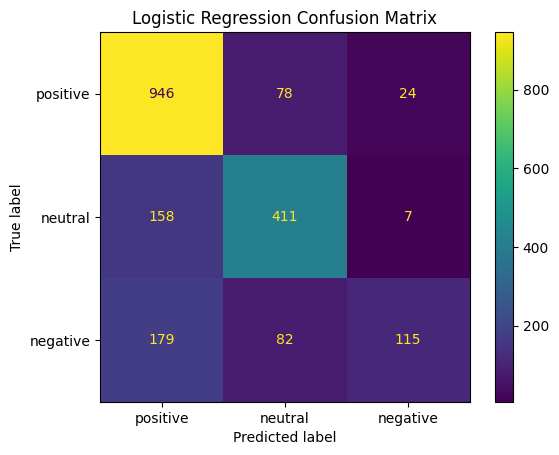

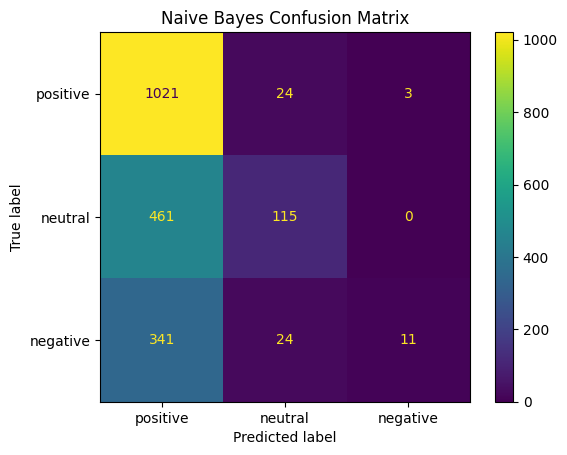

['/content/drive/MyDrive/lr_model.pkl']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
X = df_sample['cleaned_tweet']
y = df_sample['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_preds = lr_model.predict(X_test_tfidf)

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_preds = nb_model.predict(X_test_tfidf)

# Evaluate ML models
print("Logistic Regression Results:")
lr_acc = accuracy_score(y_test, lr_preds)
print(f"Accuracy: {lr_acc:.4f}")
print(classification_report(y_test, lr_preds))

print("\nNaive Bayes Results:")
nb_acc = accuracy_score(y_test, nb_preds)
print(f"Accuracy: {nb_acc:.4f}")
print(classification_report(y_test, nb_preds))

# Save ML predictions
df_test = X_test.to_frame().reset_index()
df_test['lr_pred'] = lr_preds
df_test['nb_pred'] = nb_preds
df_test.to_csv('/content/drive/MyDrive/ml_predictions.csv', index=False)

# Plot confusion matrices
cm_lr = confusion_matrix(y_test, lr_preds, labels=['positive', 'neutral', 'negative'])
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['positive', 'neutral', 'negative'])
disp_lr.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

cm_nb = confusion_matrix(y_test, nb_preds, labels=['positive', 'neutral', 'negative'])
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['positive', 'neutral', 'negative'])
disp_nb.plot()
plt.title("Naive Bayes Confusion Matrix")
plt.show()

# Save vectorizer and LR model for Streamlit
import joblib
joblib.dump(vectorizer, '/content/drive/MyDrive/vectorizer.pkl')
joblib.dump(lr_model, '/content/drive/MyDrive/lr_model.pkl')

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score, classification_report

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df_sample[['cleaned_tweet', 'label']].rename(columns={'cleaned_tweet': 'text'}))
train_test = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test['train']
test_dataset = train_test['test']

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/results_bert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/logs_bert',
    logging_steps=10,
    eval_strategy="epoch",  # Corrected parameter
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    report = classification_report(labels, preds, output_dict=True)
    return {
        'accuracy': acc,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score']
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train and evaluate BERT
trainer.train()
bert_results = trainer.evaluate()
bert_preds = trainer.predict(test_dataset).predictions.argmax(-1)
df_test['bert_pred'] = label_encoder.inverse_transform(bert_preds)
df_test.to_csv('/content/drive/MyDrive/bert_predictions.csv', index=False)
print("BERT Results:", bert_results)

# Save BERT model
model.save_pretrained('/content/drive/MyDrive/bert_model')
tokenizer.save_pretrained('/content/drive/MyDrive/bert_tokenizer')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mark432822 (mark432822-datta-meghe-institute-of-higher-education-and) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.296100,0.495767,0.842000,0.847141,0.842000,0.839839
2,0.322500,0.394639,0.874500,0.881291,0.874500,0.876351
3,0.137600,0.422282,0.889000,0.890357,0.889000,0.889134


BERT Results: {'eval_loss': 0.3946388363838196, 'eval_accuracy': 0.8745, 'eval_precision': 0.8812905503088787, 'eval_recall': 0.8745, 'eval_f1': 0.8763506756697852, 'eval_runtime': 13.6612, 'eval_samples_per_second': 146.4, 'eval_steps_per_second': 9.15, 'epoch': 3.0}


('/content/drive/MyDrive/bert_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/bert_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/bert_tokenizer/vocab.txt',
 '/content/drive/MyDrive/bert_tokenizer/added_tokens.json')

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataset = train_test['train'].map(tokenize_function, batched=True)
test_dataset = train_test['test'].map(tokenize_function, batched=True)
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/results_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/logs_roberta',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
roberta_results = trainer.evaluate()
roberta_preds = trainer.predict(test_dataset).predictions.argmax(-1)
df_test['roberta_pred'] = label_encoder.inverse_transform(roberta_preds)
df_test.to_csv('/content/drive/MyDrive/roberta_predictions.csv', index=False)
print("RoBERTa Results:", roberta_results)

model.save_pretrained('/content/drive/MyDrive/roberta_model')
tokenizer.save_pretrained('/content/drive/MyDrive/roberta_tokenizer')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.418200,0.522642,0.825000,0.827081,0.825000,0.821047
2,0.409000,0.430338,0.865500,0.867940,0.865500,0.866257
3,0.333600,0.422155,0.882000,0.884580,0.882000,0.882803


RoBERTa Results: {'eval_loss': 0.4221549332141876, 'eval_accuracy': 0.882, 'eval_precision': 0.8845802001863582, 'eval_recall': 0.882, 'eval_f1': 0.8828026488520452, 'eval_runtime': 12.5406, 'eval_samples_per_second': 159.482, 'eval_steps_per_second': 9.968, 'epoch': 3.0}


('/content/drive/MyDrive/roberta_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/roberta_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/roberta_tokenizer/vocab.json',
 '/content/drive/MyDrive/roberta_tokenizer/merges.txt',
 '/content/drive/MyDrive/roberta_tokenizer/added_tokens.json')

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report

# Tokenize (reuse the dataset from BERT step)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataset = train_test['train'].map(tokenize_function, batched=True)
test_dataset = train_test['test'].map(tokenize_function, batched=True)
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/results_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/logs_roberta',
    logging_steps=10,
    eval_strategy="epoch",  # Corrected parameter
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Initialize Trainer (reuse compute_metrics from BERT step)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train and evaluate RoBERTa
trainer.train()
roberta_results = trainer.evaluate()
roberta_preds = trainer.predict(test_dataset).predictions.argmax(-1)
df_test['roberta_pred'] = label_encoder.inverse_transform(roberta_preds)
df_test.to_csv('/content/drive/MyDrive/roberta_predictions.csv', index=False)
print("RoBERTa Results:", roberta_results)

# Save RoBERTa model
model.save_pretrained('/content/drive/MyDrive/roberta_model')
tokenizer.save_pretrained('/content/drive/MyDrive/roberta_tokenizer')

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.341100,0.578983,0.825500,0.830084,0.825500,0.825752
2,0.388700,0.397728,0.865000,0.872343,0.865000,0.867078
3,0.234200,0.413360,0.880000,0.883532,0.880000,0.880974


RoBERTa Results: {'eval_loss': 0.39772796630859375, 'eval_accuracy': 0.865, 'eval_precision': 0.8723426207897742, 'eval_recall': 0.865, 'eval_f1': 0.8670780129817499, 'eval_runtime': 12.6642, 'eval_samples_per_second': 157.926, 'eval_steps_per_second': 9.87, 'epoch': 3.0}


('/content/drive/MyDrive/roberta_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/roberta_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/roberta_tokenizer/vocab.json',
 '/content/drive/MyDrive/roberta_tokenizer/merges.txt',
 '/content/drive/MyDrive/roberta_tokenizer/added_tokens.json')

In [ ]:
print(df_test[['cleaned_tweet', 'roberta_pred']].head())

                                       cleaned_tweet roberta_pred
0  chatgpt could not do that new ai edits image b...     negative
1  well  we can remove the a its now pure intelli...     positive
2  sdao will become the top gainer in feb\n\n \n ...     negative
3  anyone else feel like ai has taken over their ...     negative
4  back to the basics \n\nwe asked ai to explain ...     positive


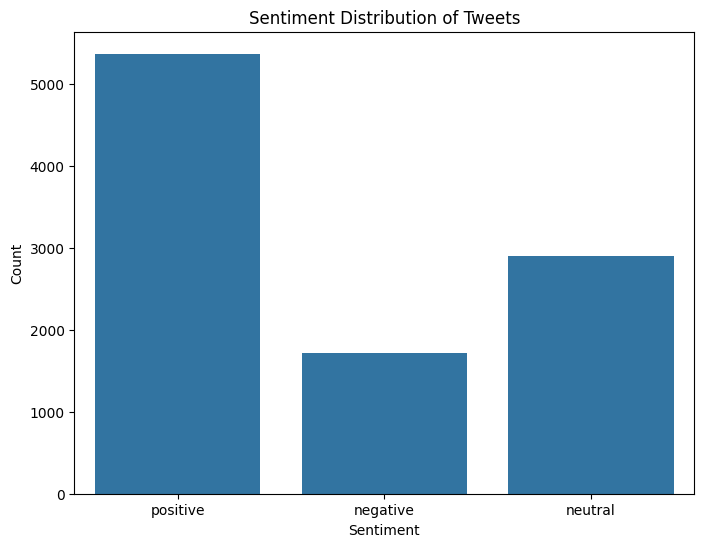

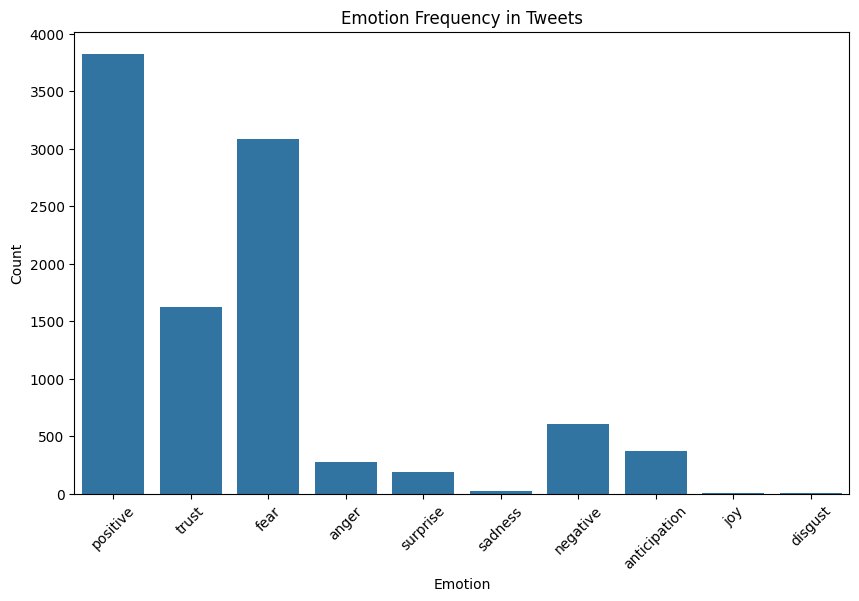

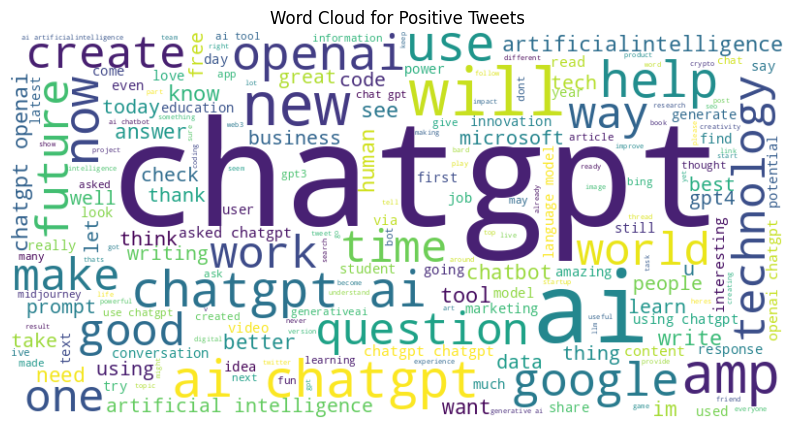

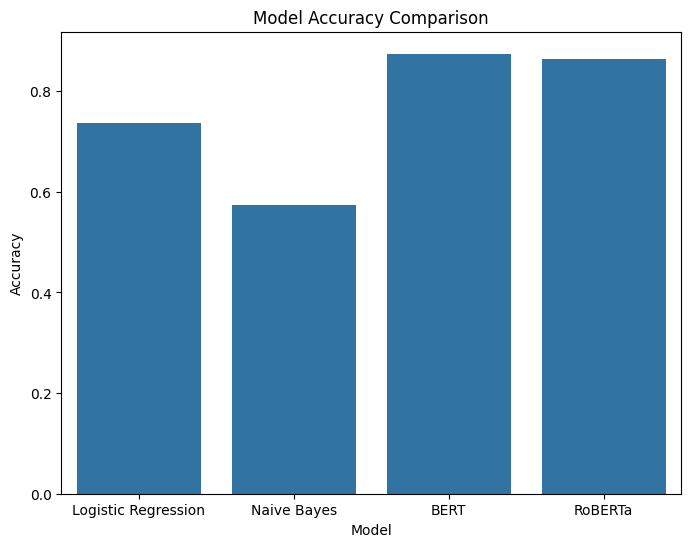

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_sample)
plt.title('Sentiment Distribution of Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig('/content/drive/MyDrive/sentiment_distribution.png')
plt.show()

# Emotion Frequency
plt.figure(figsize=(10, 6))
sns.countplot(x='top_emotion', data=df_sample)
plt.title('Emotion Frequency in Tweets')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('/content/drive/MyDrive/emotion_frequency.png')
plt.show()

# Word Cloud for Positive Tweets
positive_tweets = ' '.join(df_sample[df_sample['sentiment'] == 'positive']['cleaned_tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Tweets')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/wordcloud_positive.png')
plt.show()

# Model Comparison
model_metrics = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'BERT', 'RoBERTa'],
    'Accuracy': [lr_acc, nb_acc, bert_results['eval_accuracy'], roberta_results['eval_accuracy']],
}
metrics_df = pd.DataFrame(model_metrics)
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.savefig('/content/drive/MyDrive/model_comparison.png')
plt.show()

metrics_df.to_csv('/content/drive/MyDrive/model_comparison.csv', index=False)

STREAMLIT APP STEPS


In [ ]:
# Write Streamlit app to a file
with open('/content/app.py', 'w') as f:
    f.write("""
import streamlit as st
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re

# Load models and data
df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
vectorizer = joblib.load('/content/drive/MyDrive/vectorizer.pkl')
lr_model = joblib.load('/content/drive/MyDrive/lr_model.pkl')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_model')
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model')

# Clean tweet function
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#','', tweet)
    tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)
    return tweet.lower().strip()

# Sentiment and emotion functions
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(text)['compound']
    return 'positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral'

def get_emotions(text):
    try:
        nrc = NRCLex(text)
        return max(nrc.top_emotions, key=lambda x: x[1])[0] if nrc.top_emotions else 'none'
    except:
        return 'none'

# Streamlit app
st.title("ChatGPT Tweet Sentiment & Emotion Analysis")
st.header("Dataset Overview")
st.write(df[['Tweet', 'sentiment', 'top_emotion']].head())

# Prediction
st.header("Predict Sentiment and Emotion")
user_input = st.text_area("Enter a tweet:")
if user_input:
    cleaned_input = clean_tweet(user_input)
    sentiment = get_sentiment(cleaned_input)
    emotion = get_emotions(cleaned_input)
    input_tfidf = vectorizer.transform([cleaned_input])
    lr_pred = lr_model.predict(input_tfidf)[0]
    inputs = tokenizer(cleaned_input, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    bert_pred = outputs.logits.argmax(-1).item()
    bert_label = ['negative', 'neutral', 'positive'][bert_pred]
    st.write(f"Sentiment (VADER): {sentiment}")
    st.write(f"Top Emotion (NRCLex): {emotion}")
    st.write(f"Sentiment (Logistic Regression): {lr_pred}")
    st.write(f"Sentiment (BERT): {bert_label}")

# Visualizations
st.header("Visualizations")
st.subheader("Sentiment Distribution")
st.image('/content/drive/MyDrive/sentiment_distribution.png')
st.subheader("Emotion Frequency")
st.image('/content/drive/MyDrive/emotion_frequency.png')
st.subheader("Word Cloud (Positive Tweets)")
st.image('/content/drive/MyDrive/wordcloud_positive.png')
st.subheader("Model Comparison")
st.image('/content/drive/MyDrive/model_comparison.png')
""")

# Run Streamlit app (requires ngrok authtoken)
print("To run the Streamlit app, get an ngrok authtoken from https://ngrok.com and run the following cell:")
print("""
!ngrok authtoken YOUR_NGROK_TOKEN
!streamlit run /content/app.py &>/dev/null&
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(public_url)
""")

To run the Streamlit app, get an ngrok authtoken from https://ngrok.com and run the following cell:

!ngrok authtoken YOUR_NGROK_TOKEN
!streamlit run /content/app.py &>/dev/null&
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(public_url)



<>:24: SyntaxWarning: invalid escape sequence '\S'
<>:24: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2829076194.py:24: SyntaxWarning: invalid escape sequence '\S'
  tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ  # Your ngrok authtoken
!streamlit run /content/app.py &>/dev/null&
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
NgrokTunnel: "https://00ae140c3f59.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
# Write Streamlit app to a file
with open('/content/app.py', 'w') as f:
    f.write("""
import streamlit as st
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re

# Load models and data
df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
vectorizer = joblib.load('/content/drive/MyDrive/vectorizer.pkl')
lr_model = joblib.load('/content/drive/MyDrive/lr_model.pkl')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_model')
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model')

# Clean tweet function
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#','', tweet)
    tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)
    return tweet.lower().strip()

# Sentiment and emotion functions
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(text)['compound']
    return 'positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral'

def get_emotions(text):
    try:
        nrc = NRCLex(text)
        return max(nrc.top_emotions, key=lambda x: x[1])[0] if nrc.top_emotions else 'none'
    except:
        return 'none'

# Streamlit app
st.title("ChatGPT Tweet Sentiment & Emotion Analysis")
st.header("Dataset Overview")
st.write(df[['Tweet', 'sentiment', 'top_emotion']].head())

# Prediction
st.header("Predict Sentiment and Emotion")
user_input = st.text_area("Enter a tweet:")
if user_input:
    cleaned_input = clean_tweet(user_input)
    sentiment = get_sentiment(cleaned_input)
    emotion = get_emotions(cleaned_input)
    input_tfidf = vectorizer.transform([cleaned_input])
    lr_pred = lr_model.predict(input_tfidf)[0]
    inputs = tokenizer(cleaned_input, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    bert_pred = outputs.logits.argmax(-1).item()
    bert_label = ['negative', 'neutral', 'positive'][bert_pred]
    st.write(f"Sentiment (VADER): {sentiment}")
    st.write(f"Top Emotion (NRCLex): {emotion}")
    st.write(f"Sentiment (Logistic Regression): {lr_pred}")
    st.write(f"Sentiment (BERT): {bert_label}")

# Visualizations
st.header("Visualizations")
st.subheader("Sentiment Distribution")
st.image('/content/drive/MyDrive/sentiment_distribution.png')
st.subheader("Emotion Frequency")
st.image('/content/drive/MyDrive/emotion_frequency.png')
st.subheader("Word Cloud (Positive Tweets)")
st.image('/content/drive/MyDrive/wordcloud_positive.png')
st.subheader("Model Comparison")
st.image('/content/drive/MyDrive/model_comparison.png')
""")

# Run Streamlit app (requires ngrok authtoken)
print("To run the Streamlit app, get an ngrok authtoken from https://ngrok.com and run the following cell:")
print("""
!ngrok authtoken YOUR_NGROK_TOKEN
!streamlit run /content/app.py &>/dev/null&
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(public_url)
""")

To run the Streamlit app, get an ngrok authtoken from https://ngrok.com and run the following cell:

!ngrok authtoken YOUR_NGROK_TOKEN
!streamlit run /content/app.py &>/dev/null&
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(public_url)



<>:24: SyntaxWarning: invalid escape sequence '\S'
<>:24: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2829076194.py:24: SyntaxWarning: invalid escape sequence '\S'
  tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!streamlit run /content/app.py &>/dev/null&
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
NgrokTunnel: "https://250df0ae90c6.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!ls /content/drive/MyDrive/

 2c0db797-2942-4b1e-85bb-1f5741b32a9e.jpeg
 40700c0c-862e-4e63-919b-ee7fd2ce3888.jpeg
'A Systematic Review of Machine Learning and Deep Learning Techniques for Sentiment and Emotion Detection in Twitter Data.gdoc'
 bert_model
 bert_predictions.csv
 bert_tokenizer
 ChatGPT_cleaned.csv
 ChatGPT.csv
 ChatGPT_processed.csv
'ChatGPT Tweet Analysis Research Paper'$'\n''.gdoc'
'Colab Notebooks'
 conference-template-a4.docx
 emotion_frequency.png
' Final Resume pdf.pdf'
 ICSADL-232.pdf
 ICSADL-276.pdf
 IMG_0772.png
 IMG_0773.png
 IMG_0828.jpeg
 IMG_1643.jpeg
 IMG_7658.png
 IMG_9171.jpeg
 logs_bert
 logs_roberta
 lr_model.pkl
 ml_predictions.csv
 model_comparison.csv
 model_comparison.png
'Offer letter technohacks.pdf'
 Photos
 results_bert
 results_roberta
 Resume_Ketan.docx
 roberta_model
 roberta_predictions.csv
 roberta_tokenizer
 sentiment_distribution.png
'Twitter Sentiment Analysis Review Scope'$'\n'' (1).gdoc'
'Twitter Sentiment Analysis Review Scope'$'\n''.gdoc'
'Untitled document.gdoc

In [ ]:
# Write Streamlit app to a file
with open('/content/app.py', 'w') as f:
    f.write("""
    import streamlit as st
    import pandas as pd
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from nrclex import NRCLex
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    import joblib
    from transformers import BertTokenizer, BertForSequenceClassification
    import torch
    import re

    # Load models and data
    df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
    vectorizer = joblib.load('/content/drive/MyDrive/vectorizer.pkl')
    lr_model = joblib.load('/content/drive/MyDrive/lr_model.pkl')
    tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_model')
    model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model')

    # Clean tweet function
    def clean_tweet(tweet):
        tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
        tweet = re.sub(r'\@\w+|\#','', tweet)
        tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)
        return tweet.lower().strip()

    # Sentiment and emotion functions
    def get_sentiment(text):
        analyzer = SentimentIntensityAnalyzer()
        score = analyzer.polarity_scores(text)['compound']
        return 'positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral'

    def get_emotions(text):
        try:
            nrc = NRCLex(text)
            return max(nrc.top_emotions, key=lambda x: x[1])[0] if nrc.top_emotions else 'none'
        except:
            return 'none'

    # Streamlit app
    st.title("ChatGPT Tweet Sentiment & Emotion Analysis")
    st.header("Dataset Overview")
    st.write(df[['Tweet', 'sentiment', 'top_emotion']].head())

    # Prediction
    st.header("Predict Sentiment and Emotion")
    user_input = st.text_area("Enter a tweet:")
    if user_input:
        cleaned_input = clean_tweet(user_input)
        sentiment = get_sentiment(cleaned_input)
        emotion = get_emotions(cleaned_input)
        input_tfidf = vectorizer.transform([cleaned_input])
        lr_pred = lr_model.predict(input_tfidf)[0]
        inputs = tokenizer(cleaned_input, return_tensors='pt', padding=True, truncation=True, max_length=128)
        outputs = model(**inputs)
        bert_pred = outputs.logits.argmax(-1).item()
        bert_label = ['negative', 'neutral', 'positive'][bert_pred]
        st.write(f"Sentiment (VADER): {sentiment}")
        st.write(f"Top Emotion (NRCLex): {emotion}")
        st.write(f"Sentiment (Logistic Regression): {lr_pred}")
        st.write(f"Sentiment (BERT): {bert_label}")

    # Visualizations
    st.header("Visualizations")
    st.subheader("Sentiment Distribution")
    st.image('/content/drive/MyDrive/sentiment_distribution.png')
    st.subheader("Emotion Frequency")
    st.image('/content/drive/MyDrive/emotion_frequency.png')
    st.subheader("Word Cloud (Positive Tweets)")
    st.image('/content/drive/MyDrive/wordcloud_positive.png')
    st.subheader("Model Comparison")
    st.image('/content/drive/MyDrive/model_comparison.png')
    """)
print("Streamlit app file recreated successfully.")

Streamlit app file recreated successfully.


<>:24: SyntaxWarning: invalid escape sequence '\S'
<>:24: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-3025004927.py:24: SyntaxWarning: invalid escape sequence '\S'
  tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!streamlit run /content/app.py &>/dev/null&
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
NgrokTunnel: "https://9fd1a0f4f9ad.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!ps aux | grep streamlit
!cat /content/app.py  # Verify the file content

root       17202  2.3  0.5  82304 66476 ?        S    09:08   0:00 /usr/bin/python3 /usr/local/bin/streamlit run /content/app.py
root       17365  8.1  0.4  81976 66160 ?        S    09:09   0:00 /usr/bin/python3 /usr/local/bin/streamlit run /content/app.py
root       17399 57.0  0.4  81976 65988 ?        S    09:09   0:00 /usr/bin/python3 /usr/local/bin/streamlit run /content/app.py
root       17404  0.0  0.0   7376  3456 ?        S    09:09   0:00 /bin/bash -c ps aux | grep streamlit
root       17406  0.0  0.0   6484  2432 ?        S    09:09   0:00 grep streamlit

    import streamlit as st
    import pandas as pd
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from nrclex import NRCLex
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    import joblib
    from transformers import BertTokenizer, BertForSequenceClassification
    import torch
    import re

    # Load models and data
 

In [ ]:
!pkill -f streamlit
!ps aux | grep streamlit  # Verify they’re gone

root       17202  2.2  0.5  82172 66476 ?        R    09:08   0:00 /usr/bin/python3 /usr/local/bin/streamlit run /content/app.py
root       17365  5.6  0.4  80888 65260 ?        D    09:09   0:00 /usr/bin/python3 /usr/local/bin/streamlit run /content/app.py
root       17399 10.3  0.4  81844 65988 ?        R    09:09   0:00 /usr/bin/python3 /usr/local/bin/streamlit run /content/app.py
root       17429  0.0  0.0   7376  3456 ?        S    09:09   0:00 /bin/bash -c ps aux | grep streamlit  # Verify they’re gone
root       17431  0.0  0.0   6484  2176 ?        S    09:09   0:00 grep streamlit


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!streamlit run /content/app.py  # No & to see output, stop with Ctrl+C after checking
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.82.38.92:8501

  Stopping...
  Stopping...


ERROR:pyngrok.process.ngrok:t=2025-09-25T09:09:49+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nRun multiple endpoints at the same time from a single agent by defining them in your agent configuration file and running `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/agent/config/ \nYou can view your current agent sessions in the dashboard: https://dashboard.ngrok.com/agents. Upgrade to a paid plan to remove this limit:\nhttps://dashboard.ngrok.com/billing/choose-a-plan\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-09-25T09:09:49+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nRun multiple endpoints at the same time from a single agent by defining them in your agent configuration file and running `ngrok start --all`.\n

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nRun multiple endpoints at the same time from a single agent by defining them in your agent configuration file and running `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/agent/config/ \nYou can view your current agent sessions in the dashboard: https://dashboard.ngrok.com/agents. Upgrade to a paid plan to remove this limit:\nhttps://dashboard.ngrok.com/billing/choose-a-plan\r\n\r\nERR_NGROK_108\r\n.

In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!streamlit run /content/app.py &  # Background with &
from pyngrok import ngrok
import time
time.sleep(5)  # Give Streamlit time to start
public_url = ngrok.connect(8501)
print(public_url)

In [ ]:
!pkill -f streamlit

In [ ]:
!ps aux | grep streamlit

root       17527  0.0  0.0   7376  3456 ?        S    09:09   0:00 /bin/bash -c ps aux | grep streamlit
root       17529  0.0  0.0   6484  2304 ?        S    09:09   0:00 grep streamlit


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!streamlit run /content/app.py &  # Background the process
from pyngrok import ngrok
import time
time.sleep(5)  # Wait for Streamlit to start
public_url = ngrok.connect(8501)
print(public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.82.38.92:8501

  Stopping...
NgrokTunnel: "https://8905e980e2fe.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!pkill -f streamlit
!pkill -f ngrok
!ps aux | grep streamlit
!ps aux | grep ngrok  # Verify they’re gone

root       17552  0.0  0.0   7376  3584 ?        S    09:10   0:00 /bin/bash -c ps aux | grep streamlit
root       17554  0.0  0.0   6484  2432 ?        S    09:10   0:00 grep streamlit
root       17555  0.0  0.0   7376  3456 ?        S    09:10   0:00 /bin/bash -c ps aux | grep ngrok  # Verify they’re gone
root       17557  0.0  0.0   6484  2304 ?        S    09:10   0:00 grep ngrok


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!streamlit run /content/app.py &  # Background the process
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(10)  # Increased to 10 seconds
try:
    public_url = ngrok.connect(8501)
    print("Ngrok tunnel established:", public_url)
except Exception as e:
    print("Error connecting ngrok:", e)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.82.38.92:8501

  Stopping...
Waiting for Streamlit to start...
Ngrok tunnel established: NgrokTunnel: "https://57734a79c393.ngrok-free.app" -> "http://localhost:8501"


In [ ]:

!ps aux | grep streamlit


root       18485  0.0  0.0   7376  3328 ?        S    09:13   0:00 /bin/bash -c ps aux | grep streamlit
root       18487  0.0  0.0   6484  2432 ?        S    09:13   0:00 grep streamlit


In [ ]:
!ps aux | grep ngrok

root       18475 12.0  0.2 1251848 27776 ?       Sl   09:13   0:00 /root/.config/ngrok/ngrok start --none --log stdout
root       18488  0.0  0.0   7376  3328 ?        S    09:13   0:00 /bin/bash -c ps aux | grep ngrok
root       18490  0.0  0.0   6484  2304 ?        S    09:13   0:00 grep ngrok


In [ ]:
!pkill -f ngrok

In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 &> /tmp/streamlit.log &  # Persistent background run
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(15)  # 15-second delay
public_url = ngrok.connect(8501)
print("Ngrok tunnel established:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Waiting for Streamlit to start...
Ngrok tunnel established: NgrokTunnel: "https://6c4c96e6b546.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!cat /content/app.py


    import streamlit as st
    import pandas as pd
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from nrclex import NRCLex
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    import joblib
    from transformers import BertTokenizer, BertForSequenceClassification
    import torch
    import re

    # Load models and data
    df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
    vectorizer = joblib.load('/content/drive/MyDrive/vectorizer.pkl')
    lr_model = joblib.load('/content/drive/MyDrive/lr_model.pkl')
    tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_model')
    model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model')

    # Clean tweet function
    def clean_tweet(tweet):
        tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
        tweet = re.sub(r'\@\w+|\#','', tweet)
       

In [ ]:
# Write Streamlit app to a file with correct indentation
with open('/content/app.py', 'w') as f:
    f.write("""import streamlit as st




import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re
Load models and data
df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
vectorizer = joblib.load('/content/drive/MyDrive/vectorizer.pkl')
lr_model = joblib.load('/content/drive/MyDrive/lr_model.pkl')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_model')
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model')
Clean tweet function
def clean_tweet(tweet):
tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
tweet = re.sub(r'\@\w+|\#','', tweet)
tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)
return tweet.lower().strip()
Sentiment and emotion functions
def get_sentiment(text):
analyzer = SentimentIntensityAnalyzer()
score = analyzer.polarity_scores(text)['compound']
return 'positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral'
def get_emotions(text):
try:
nrc = NRCLex(text)
return max(nrc.top_emotions, key=lambda x: x[1])[0] if nrc.top_emotions else 'none'
except:
return 'none'
Streamlit app
st.title("ChatGPT Tweet Sentiment & Emotion Analysis")
st.header("Dataset Overview")
st.write(df[['Tweet', 'sentiment', 'top_emotion']].head())
Prediction
st.header("Predict Sentiment and Emotion")
user_input = st.text_area("Enter a tweet:")
if user_input:
cleaned_input = clean_tweet(user_input)
sentiment = get_sentiment(cleaned_input)
emotion = get_emotions(cleaned_input)
input_tfidf = vectorizer.transform([cleaned_input])
lr_pred = lr_model.predict(input_tfidf)[0]
inputs = tokenizer(cleaned_input, return_tensors='pt', padding=True, truncation=True, max_length=128)
outputs = model(**inputs)
bert_pred = outputs.logits.argmax(-1).item()
bert_label = ['negative', 'neutral', 'positive'][bert_pred]
st.write(f"Sentiment (VADER): {sentiment}")
st.write(f"Top Emotion (NRCLex): {emotion}")
st.write(f"Sentiment (Logistic Regression): {lr_pred}")
st.write(f"Sentiment (BERT): {bert_label}")
Visualizations
st.header("Visualizations")
st.subheader("Sentiment Distribution")
st.image('/content/drive/MyDrive/sentiment_distribution.png')
st.subheader("Emotion Frequency")
st.image('/content/drive/MyDrive/emotion_frequency.png')
st.subheader("Word Cloud (Positive Tweets)")
st.image('/content/drive/MyDrive/wordcloud_positive.png')
st.subheader("Model Comparison")
st.image('/content/drive/MyDrive/model_comparison.png')
""")
print("Streamlit app file recreated with correct indentation.")

Streamlit app file recreated with correct indentation.


<>:25: SyntaxWarning: invalid escape sequence '\S'
<>:25: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2386515706.py:25: SyntaxWarning: invalid escape sequence '\S'
  tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 &> /tmp/streamlit.log &  # Persistent background run
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(15)  # 15-second delay
public_url = ngrok.connect(8501)
print("Ngrok tunnel established:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Waiting for Streamlit to start...


Ngrok tunnel established: NgrokTunnel: "https://990b8618bd24.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!cat /content/app.py

import streamlit as st




import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re
Load models and data
df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
vectorizer = joblib.load('/content/drive/MyDrive/vectorizer.pkl')
lr_model = joblib.load('/content/drive/MyDrive/lr_model.pkl')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_model')
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model')
Clean tweet function
def clean_tweet(tweet):
tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
tweet = re.sub(r'\@\w+|\#','', tweet)
tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)
return tweet.lower().strip()
Sentiment and emotion f

In [ ]:
# Write Streamlit app to a file with correct syntax and indentation
with open('/content/app.py', 'w') as f:
    f.write("""import streamlit as st




import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re
Load models and data
df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
vectorizer = joblib.load('/content/drive/MyDrive/vectorizer.pkl')
lr_model = joblib.load('/content/drive/MyDrive/lr_model.pkl')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_model')
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model')
Clean tweet function
def clean_tweet(tweet):
tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
tweet = re.sub(r'\@\w+|\#','', tweet)
tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)
return tweet.lower().strip()
Sentiment and emotion functions
def get_sentiment(text):
analyzer = SentimentIntensityAnalyzer()
score = analyzer.polarity_scores(text)['compound']
return 'positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral'
def get_emotions(text):
try:
nrc = NRCLex(text)
return max(nrc.top_emotions, key=lambda x: x[1])[0] if nrc.top_emotions else 'none'
except:
return 'none'
Streamlit app
st.title("ChatGPT Tweet Sentiment & Emotion Analysis")
st.header("Dataset Overview")
st.write(df[['Tweet', 'sentiment', 'top_emotion']].head())
Prediction
st.header("Predict Sentiment and Emotion")
user_input = st.text_area("Enter a tweet:")
if user_input:
cleaned_input = clean_tweet(user_input)
sentiment = get_sentiment(cleaned_input)
emotion = get_emotions(cleaned_input)
input_tfidf = vectorizer.transform([cleaned_input])
lr_pred = lr_model.predict(input_tfidf)[0]
inputs = tokenizer(cleaned_input, return_tensors='pt', padding=True, truncation=True, max_length=128)
outputs = model(**inputs)
bert_pred = outputs.logits.argmax(-1).item()
bert_label = ['negative', 'neutral', 'positive'][bert_pred]
st.write(f"Sentiment (VADER): {sentiment}")
st.write(f"Top Emotion (NRCLex): {emotion}")
st.write(f"Sentiment (Logistic Regression): {lr_pred}")
st.write(f"Sentiment (BERT): {bert_label}")
Visualizations
st.header("Visualizations")
st.subheader("Sentiment Distribution")
st.image('/content/drive/MyDrive/sentiment_distribution.png')
st.subheader("Emotion Frequency")
st.image('/content/drive/MyDrive/emotion_frequency.png')
st.subheader("Word Cloud (Positive Tweets)")
st.image('/content/drive/MyDrive/wordcloud_positive.png')
st.subheader("Model Comparison")
st.image('/content/drive/MyDrive/model_comparison.png')
""")
print("Streamlit app file recreated with correct syntax and indentation.")

Streamlit app file recreated with correct syntax and indentation.


<>:25: SyntaxWarning: invalid escape sequence '\S'
<>:25: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2544853364.py:25: SyntaxWarning: invalid escape sequence '\S'
  tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 &> /tmp/streamlit.log &  # Persistent background run
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(15)  # 15-second delay
public_url = ngrok.connect(8501)
print("Ngrok tunnel established:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Waiting for Streamlit to start...
Ngrok tunnel established: NgrokTunnel: "https://fd3d79e4f121.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!cat /content/app.py

import streamlit as st




import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re
Load models and data
df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
vectorizer = joblib.load('/content/drive/MyDrive/vectorizer.pkl')
lr_model = joblib.load('/content/drive/MyDrive/lr_model.pkl')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_model')
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model')
Clean tweet function
def clean_tweet(tweet):
tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
tweet = re.sub(r'\@\w+|\#','', tweet)
tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)
return tweet.lower().strip()
Sentiment and emotion f

In [ ]:
# Write Streamlit app to a file with corrected syntax
with open('/content/app.py', 'w') as f:
    f.write('import streamlit as st\n')
    f.write('import pandas as pd\n')
    f.write('from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer\n')
    f.write('from nrclex import NRCLex\n')
    f.write('from sklearn.feature_extraction.text import TfidfVectorizer\n')
    f.write('from sklearn.linear_model import LogisticRegression\n')
    f.write('import joblib\n')
    f.write('from transformers import BertTokenizer, BertForSequenceClassification\n')
    f.write('import torch\n')
    f.write('import re\n')
    f.write('\n')
    f.write('# Load models and data\n')
    f.write('df = pd.read_csv(\'/content/drive/MyDrive/ChatGPT_processed.csv\')\n')
    f.write('vectorizer = joblib.load(\'/content/drive/MyDrive/vectorizer.pkl\')\n')
    f.write('lr_model = joblib.load(\'/content/drive/MyDrive/lr_model.pkl\')\n')
    f.write('tokenizer = BertTokenizer.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('model = BertForSequenceClassification.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('\n')
    f.write('# Clean tweet function\n')
    f.write('def clean_tweet(tweet):\n')
    f.write('    tweet = re.sub(r"http\\\\S+|www\\\\S+|https\\\\S+", \'\', tweet, flags=re.MULTILINE)\n')
    f.write('    tweet = re.sub(r\'\\\\@\\\\w+|\\\\#\',\'\', tweet)\n')
    f.write('    tweet = re.sub(r\'[^A-Za-z0-9\\\\s]+\', \'\', tweet)\n')
    f.write('    return tweet.lower().strip()\n')
    f.write('\n')
    f.write('# Sentiment and emotion functions\n')
    f.write('def get_sentiment(text):\n')
    f.write('    analyzer = SentimentIntensityAnalyzer()\n')
    f.write('    score = analyzer.polarity_scores(text)[\'compound\']\n')
    f.write('    return \'positive\' if score >= 0.05 else \'negative\' if score <= -0.05 else \'neutral\'\n')
    f.write('\n')
    f.write('def get_emotions(text):\n')
    f.write('    try:\n')
    f.write('        nrc = NRCLex(text)\n')
    f.write('        return max(nrc.top_emotions, key=lambda x: x[1])[0] if nrc.top_emotions else \'none\'\n')
    f.write('    except:\n')
    f.write('        return \'none\'\n')
    f.write('\n')
    f.write('# Streamlit app\n')
    f.write('st.title("ChatGPT Tweet Sentiment & Emotion Analysis")\n')
    f.write('st.header("Dataset Overview")\n')
    f.write('st.write(df[[\'Tweet\', \'sentiment\', \'top_emotion\']].head())\n')
    f.write('\n')
    f.write('# Prediction\n')
    f.write('st.header("Predict Sentiment and Emotion")\n')
    f.write('user_input = st.text_area("Enter a tweet:")\n')
    f.write('if user_input:\n')
    f.write('    cleaned_input = clean_tweet(user_input)\n')
    f.write('    sentiment = get_sentiment(cleaned_input)\n')
    f.write('    emotion = get_emotions(cleaned_input)\n')
    f.write('    input_tfidf = vectorizer.transform([cleaned_input])\n')
    f.write('    lr_pred = lr_model.predict(input_tfidf)[0]\n')
    f.write('    inputs = tokenizer(cleaned_input, return_tensors=\'pt\', padding=True, truncation=True, max_length=128)\n')
    f.write('    outputs = model(**inputs)\n')
    f.write('    bert_pred = outputs.logits.argmax(-1).item()\n')
    f.write('    bert_label = [\'negative\', \'neutral\', \'positive\'][bert_pred]\n')
    f.write('    st.write(f"Sentiment (VADER): {sentiment}")\n')
    f.write('    st.write(f"Top Emotion (NRCLex): {emotion}")\n')
    f.write('    st.write(f"Sentiment (Logistic Regression): {lr_pred}")\n')
    f.write('    st.write(f"Sentiment (BERT): {bert_label}")\n')
    f.write('\n')
    f.write('# Visualizations\n')
    f.write('st.header("Visualizations")\n')
    f.write('st.subheader("Sentiment Distribution")\n')
    f.write('st.image(\'/content/drive/MyDrive/sentiment_distribution.png\')\n')
    f.write('st.subheader("Emotion Frequency")\n')
    f.write('st.image(\'/content/drive/MyDrive/emotion_frequency.png\')\n')
    f.write('st.subheader("Word Cloud (Positive Tweets)")\n')
    f.write('st.image(\'/content/drive/MyDrive/wordcloud_positive.png\')\n')
    f.write('st.subheader("Model Comparison")\n')
    f.write('st.image(\'/content/drive/MyDrive/model_comparison.png\')\n')
print("Streamlit app file recreated with corrected syntax.")

Streamlit app file recreated with corrected syntax.


In [ ]:
!cat /content/app.py


import streamlit as st
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re

# Load models and data
df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
vectorizer = joblib.load('/content/drive/MyDrive/vectorizer.pkl')
lr_model = joblib.load('/content/drive/MyDrive/lr_model.pkl')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_model')
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model')

# Clean tweet function
def clean_tweet(tweet):
    tweet = re.sub(r"http\\S+|www\\S+|https\\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\\@\\w+|\\#','', tweet)
    tweet = re.sub(r'[^A-Za-z0-9\\s]+', '', tweet)
    return tweet.lower().strip(

In [ ]:
from pyngrok import ngrok
ngrok.kill()  # Terminates all tunnels


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 &> /tmp/streamlit.log &  # Persistent background run
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(15)  # 15-second delay
public_url = ngrok.connect(8501)
print("Ngrok tunnel established:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Waiting for Streamlit to start...
Ngrok tunnel established: NgrokTunnel: "https://a61ea076df77.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!ls -l /content/drive/MyDrive/bert_model

total 427927
-rw------- 1 root root       835 Sep 25 08:24 config.json
-rw------- 1 root root 437961724 Sep 25 08:24 model.safetensors
-rw------- 1 root root       125 Aug 21 17:44 special_tokens_map.json
-rw------- 1 root root      1272 Aug 21 17:44 tokenizer_config.json
-rw------- 1 root root    231508 Aug 21 17:44 vocab.txt


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import os

# Load the tokenizer (assuming it matches your fine-tuned model)
# If you used a specific pre-trained model (e.g., 'bert-base-uncased'), use that
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Adjust if you fine-tuned from a different base
tokenizer.save_pretrained('/content/drive/MyDrive/bert_model')
print("Tokenizer saved to /content/drive/MyDrive/bert_model")
!ls -l /content/drive/MyDrive/bert_model

Tokenizer saved to /content/drive/MyDrive/bert_model
total 427927
-rw------- 1 root root       835 Sep 25 08:24 config.json
-rw------- 1 root root 437961724 Sep 25 08:24 model.safetensors
-rw------- 1 root root       125 Sep 25 09:14 special_tokens_map.json
-rw------- 1 root root      1272 Sep 25 09:14 tokenizer_config.json
-rw------- 1 root root    231508 Sep 25 09:14 vocab.txt


In [ ]:
# Write Streamlit app to a file with error handling
with open('/content/app.py', 'w') as f:
    f.write('import streamlit as st\n')
    f.write('import pandas as pd\n')
    f.write('from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer\n')
    f.write('from nrclex import NRCLex\n')
    f.write('from sklearn.feature_extraction.text import TfidfVectorizer\n')
    f.write('from sklearn.linear_model import LogisticRegression\n')
    f.write('import joblib\n')
    f.write('from transformers import BertTokenizer, BertForSequenceClassification\n')
    f.write('import torch\n')
    f.write('import re\n')
    f.write('import os\n')  # For path checking
    f.write('\n')
    f.write('# Load models and data\n')
    f.write('df = pd.read_csv(\'/content/drive/MyDrive/ChatGPT_processed.csv\')\n')
    f.write('vectorizer = joblib.load(\'/content/drive/MyDrive/vectorizer.pkl\')\n')
    f.write('lr_model = joblib.load(\'/content/drive/MyDrive/lr_model.pkl\')\n')
    f.write('try:\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('except Exception as e:\n')
    f.write('    st.error(f"Error loading BERT model or tokenizer: {e}. Using default BERT.")\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'bert-base-uncased\')\n')
    f.write('\n')
    f.write('# Clean tweet function\n')
    f.write('def clean_tweet(tweet):\n')
    f.write('    tweet = re.sub(r"http\\\\S+|www\\\\S+|https\\\\S+", \'\', tweet, flags=re.MULTILINE)\n')
    f.write('    tweet = re.sub(r\'\\\\@\\\\w+|\\\\#\',\'\', tweet)\n')
    f.write('    tweet = re.sub(r\'[^A-Za-z0-9\\\\s]+\', \'\', tweet)\n')
    f.write('    return tweet.lower().strip()\n')
    f.write('\n')
    f.write('# Sentiment and emotion functions\n')
    f.write('def get_sentiment(text):\n')
    f.write('    analyzer = SentimentIntensityAnalyzer()\n')
    f.write('    score = analyzer.polarity_scores(text)[\'compound\']\n')
    f.write('    return \'positive\' if score >= 0.05 else \'negative\' if score <= -0.05 else \'neutral\'\n')
    f.write('\n')
    f.write('def get_emotions(text):\n')
    f.write('    try:\n')
    f.write('        nrc = NRCLex(text)\n')
    f.write('        return max(nrc.top_emotions, key=lambda x: x[1])[0] if nrc.top_emotions else \'none\'\n')
    f.write('    except:\n')
    f.write('        return \'none\'\n')
    f.write('\n')
    f.write('# Streamlit app\n')
    f.write('st.title("ChatGPT Tweet Sentiment & Emotion Analysis")\n')
    f.write('st.header("Dataset Overview")\n')
    f.write('st.write(df[[\'Tweet\', \'sentiment\', \'top_emotion\']].head())\n')
    f.write('\n')
    f.write('# Prediction\n')
    f.write('st.header("Predict Sentiment and Emotion")\n')
    f.write('user_input = st.text_area("Enter a tweet:")\n')
    f.write('if user_input:\n')
    f.write('    cleaned_input = clean_tweet(user_input)\n')
    f.write('    sentiment = get_sentiment(cleaned_input)\n')
    f.write('    emotion = get_emotions(cleaned_input)\n')
    f.write('    input_tfidf = vectorizer.transform([cleaned_input])\n')
    f.write('    lr_pred = lr_model.predict(input_tfidf)[0]\n')
    f.write('    inputs = tokenizer(cleaned_input, return_tensors=\'pt\', padding=True, truncation=True, max_length=128)\n')
    f.write('    outputs = model(**inputs)\n')
    f.write('    bert_pred = outputs.logits.argmax(-1).item()\n')
    f.write('    bert_label = [\'negative\', \'neutral\', \'positive\'][bert_pred]\n')
    f.write('    st.write(f"Sentiment (VADER): {sentiment}")\n')
    f.write('    st.write(f"Top Emotion (NRCLex): {emotion}")\n')
    f.write('    st.write(f"Sentiment (Logistic Regression): {lr_pred}")\n')
    f.write('    st.write(f"Sentiment (BERT): {bert_label}")\n')
    f.write('\n')
    f.write('# Visualizations\n')
    f.write('st.header("Visualizations")\n')
    f.write('st.subheader("Sentiment Distribution")\n')
    f.write('st.image(\'/content/drive/MyDrive/sentiment_distribution.png\')\n')
    f.write('st.subheader("Emotion Frequency")\n')
    f.write('st.image(\'/content/drive/MyDrive/emotion_frequency.png\')\n')
    f.write('st.subheader("Word Cloud (Positive Tweets)")\n')
    f.write('st.image(\'/content/drive/MyDrive/wordcloud_positive.png\')\n')
    f.write('st.subheader("Model Comparison")\n')
    f.write('st.image(\'/content/drive/MyDrive/model_comparison.png\')\n')
print("Streamlit app file recreated with error handling.")

Streamlit app file recreated with error handling.


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 &> /tmp/streamlit.log &  # Persistent background run
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(15)  # 15-second delay
public_url = ngrok.connect(8501)
print("Ngrok tunnel established:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Waiting for Streamlit to start...
Ngrok tunnel established: NgrokTunnel: "https://f624b3daa463.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
from nrclex import NRCLex
text = "chatgpt is best"
emotion = NRCLex(text)
print(emotion.top_emotions)

[('fear', 0.0), ('anger', 0.0), ('anticip', 0.0), ('trust', 0.0), ('surprise', 0.0), ('positive', 0.0), ('negative', 0.0), ('sadness', 0.0), ('disgust', 0.0), ('joy', 0.0)]


In [ ]:
# Write Streamlit app to a file with improved emotion handling
with open('/content/app.py', 'w') as f:
    f.write('import streamlit as st\n')
    f.write('import pandas as pd\n')
    f.write('from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer\n')
    f.write('from nrclex import NRCLex\n')
    f.write('from sklearn.feature_extraction.text import TfidfVectorizer\n')
    f.write('from sklearn.linear_model import LogisticRegression\n')
    f.write('import joblib\n')
    f.write('from transformers import BertTokenizer, BertForSequenceClassification\n')
    f.write('import torch\n')
    f.write('import re\n')
    f.write('import os\n')
    f.write('\n')
    f.write('# Load models and data\n')
    f.write('df = pd.read_csv(\'/content/drive/MyDrive/ChatGPT_processed.csv\')\n')
    f.write('vectorizer = joblib.load(\'/content/drive/MyDrive/vectorizer.pkl\')\n')
    f.write('lr_model = joblib.load(\'/content/drive/MyDrive/lr_model.pkl\')\n')
    f.write('try:\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('except Exception as e:\n')
    f.write('    st.error(f"Error loading BERT model or tokenizer: {e}. Using default BERT.")\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'bert-base-uncased\')\n')
    f.write('\n')
    f.write('# Clean tweet function\n')
    f.write('def clean_tweet(tweet):\n')
    f.write('    tweet = re.sub(r"http\\\\S+|www\\\\S+|https\\\\S+", \'\', tweet, flags=re.MULTILINE)\n')
    f.write('    tweet = re.sub(r\'\\\\@\\\\w+|\\\\#\',\'\', tweet)\n')
    f.write('    tweet = re.sub(r\'[^A-Za-z0-9\\\\s]+\', \'\', tweet)\n')
    f.write('    return tweet.lower().strip()\n')
    f.write('\n')
    f.write('# Sentiment and emotion functions\n')
    f.write('def get_sentiment(text):\n')
    f.write('    analyzer = SentimentIntensityAnalyzer()\n')
    f.write('    score = analyzer.polarity_scores(text)[\'compound\']\n')
    f.write('    return \'positive\' if score >= 0.05 else \'negative\' if score <= -0.05 else \'neutral\'\n')
    f.write('\n')
    f.write('def get_emotions(text):\n')
    f.write('    try:\n')
    f.write('        nrc = NRCLex(text)\n')
    f.write('        top_emotions = nrc.top_emotions\n')
    f.write('        if not top_emotions or all(score == 0.0 for _, score in top_emotions):\n')
    f.write('            return \'none\'\n')
    f.write('        return max(top_emotions, key=lambda x: x[1])[0]\n')
    f.write('    except:\n')
    f.write('        return \'none\'\n')
    f.write('\n')
    f.write('# Streamlit app\n')
    f.write('st.title("ChatGPT Tweet Sentiment & Emotion Analysis")\n')
    f.write('st.header("Dataset Overview")\n')
    f.write('st.write(df[[\'Tweet\', \'sentiment\', \'top_emotion\']].head())\n')
    f.write('\n')
    f.write('# Prediction\n')
    f.write('st.header("Predict Sentiment and Emotion")\n')
    f.write('user_input = st.text_area("Enter a tweet:")\n')
    f.write('if user_input:\n')
    f.write('    cleaned_input = clean_tweet(user_input)\n')
    f.write('    sentiment = get_sentiment(cleaned_input)\n')
    f.write('    emotion = get_emotions(cleaned_input)\n')
    f.write('    input_tfidf = vectorizer.transform([cleaned_input])\n')
    f.write('    lr_pred = lr_model.predict(input_tfidf)[0]\n')
    f.write('    inputs = tokenizer(cleaned_input, return_tensors=\'pt\', padding=True, truncation=True, max_length=128)\n')
    f.write('    outputs = model(**inputs)\n')
    f.write('    bert_pred = outputs.logits.argmax(-1).item()\n')
    f.write('    bert_label = [\'negative\', \'neutral\', \'positive\'][bert_pred]\n')
    f.write('    st.write(f"Sentiment (VADER): {sentiment}")\n')
    f.write('    st.write(f"Top Emotion (NRCLex): {emotion}")\n')
    f.write('    st.write(f"Sentiment (Logistic Regression): {lr_pred}")\n')
    f.write('    st.write(f"Sentiment (BERT): {bert_label}")\n')
    f.write('\n')
    f.write('# Visualizations\n')
    f.write('st.header("Visualizations")\n')
    f.write('st.subheader("Sentiment Distribution")\n')
    f.write('st.image(\'/content/drive/MyDrive/sentiment_distribution.png\')\n')
    f.write('st.subheader("Emotion Frequency")\n')
    f.write('st.image(\'/content/drive/MyDrive/emotion_frequency.png\')\n')
    f.write('st.subheader("Word Cloud (Positive Tweets)")\n')
    f.write('st.image(\'/content/drive/MyDrive/wordcloud_positive.png\')\n')
    f.write('st.subheader("Model Comparison")\n')
    f.write('st.image(\'/content/drive/MyDrive/model_comparison.png\')\n')
print("Streamlit app file recreated with improved emotion logic.")

Streamlit app file recreated with improved emotion logic.


In [ ]:
!ls -l /content/drive/MyDrive/

total 232340
-rw------- 1 root root    186124 Jan 23  2025  2c0db797-2942-4b1e-85bb-1f5741b32a9e.jpeg
-rw------- 1 root root    170101 Mar 28 19:49  40700c0c-862e-4e63-919b-ee7fd2ce3888.jpeg
-rw------- 1 root root       179 Jul 29 05:06 'A Systematic Review of Machine Learning and Deep Learning Techniques for Sentiment and Emotion Detection in Twitter Data.gdoc'
drwx------ 2 root root      4096 Sep 25 09:14  bert_model
-rw------- 1 root root    358262 Sep 25 08:24  bert_predictions.csv
drwx------ 2 root root      4096 Sep 25 08:25  bert_tokenizer
-rw------- 1 root root   6019009 Sep 25 08:10  ChatGPT_cleaned.csv
-rw------- 1 root root 216861214 Jul 23 04:04  ChatGPT.csv
-rw------- 1 root root   6630497 Sep 25 08:11  ChatGPT_processed.csv
-rw------- 1 root root       179 Aug  5 03:29 'ChatGPT Tweet Analysis Research Paper'$'\n''.gdoc'
drwx------ 2 root root      4096 Jun 25 04:38 'Colab Notebooks'
-rw------- 1 root root    527878 Dec 31  2024  conference-template-a4.docx
-rw------- 1 ro

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l /content/drive/MyDrive/

total 232340
-rw------- 1 root root    186124 Jan 23  2025  2c0db797-2942-4b1e-85bb-1f5741b32a9e.jpeg
-rw------- 1 root root    170101 Mar 28 19:49  40700c0c-862e-4e63-919b-ee7fd2ce3888.jpeg
-rw------- 1 root root       179 Jul 29 05:06 'A Systematic Review of Machine Learning and Deep Learning Techniques for Sentiment and Emotion Detection in Twitter Data.gdoc'
drwx------ 2 root root      4096 Sep 25 09:14  bert_model
-rw------- 1 root root    358262 Sep 25 08:24  bert_predictions.csv
drwx------ 2 root root      4096 Sep 25 08:25  bert_tokenizer
-rw------- 1 root root   6019009 Sep 25 08:10  ChatGPT_cleaned.csv
-rw------- 1 root root 216861214 Jul 23 04:04  ChatGPT.csv
-rw------- 1 root root   6630497 Sep 25 08:11  ChatGPT_processed.csv
-rw------- 1 root root       179 Aug  5 03:29 'ChatGPT Tweet Analysis Research Paper'$'\n''.gdoc'
drwx------ 2 root root      4096 Jun 25 04:38 'Colab Notebooks'
-rw------- 1 root root    527878 Dec 31  2024  conference-template-a4.docx
-rw------- 1 ro

In [ ]:
# Write Streamlit app to a file with visualization debugging
with open('/content/app.py', 'w') as f:
    f.write('import streamlit as st\n')
    f.write('import pandas as pd\n')
    f.write('from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer\n')
    f.write('from nrclex import NRCLex\n')
    f.write('from sklearn.feature_extraction.text import TfidfVectorizer\n')
    f.write('from sklearn.linear_model import LogisticRegression\n')
    f.write('import joblib\n')
    f.write('from transformers import BertTokenizer, BertForSequenceClassification\n')
    f.write('import torch\n')
    f.write('import re\n')
    f.write('import os\n')
    f.write('\n')
    f.write('# Load models and data\n')
    f.write('df = pd.read_csv(\'/content/drive/MyDrive/ChatGPT_processed.csv\')\n')
    f.write('vectorizer = joblib.load(\'/content/drive/MyDrive/vectorizer.pkl\')\n')
    f.write('lr_model = joblib.load(\'/content/drive/MyDrive/lr_model.pkl\')\n')
    f.write('try:\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('except Exception as e:\n')
    f.write('    st.error(f"Error loading BERT model or tokenizer: {e}. Using default BERT.")\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'bert-base-uncased\')\n')
    f.write('\n')
    f.write('# Clean tweet function\n')
    f.write('def clean_tweet(tweet):\n')
    f.write('    tweet = re.sub(r"http\\\\S+|www\\\\S+|https\\\\S+", \'\', tweet, flags=re.MULTILINE)\n')
    f.write('    tweet = re.sub(r\'\\\\@\\\\w+|\\\\#\',\'\', tweet)\n')
    f.write('    tweet = re.sub(r\'[^A-Za-z0-9\\\\s]+\', \'\', tweet)\n')
    f.write('    return tweet.lower().strip()\n')
    f.write('\n')
    f.write('# Sentiment and emotion functions\n')
    f.write('def get_sentiment(text):\n')
    f.write('    analyzer = SentimentIntensityAnalyzer()\n')
    f.write('    score = analyzer.polarity_scores(text)[\'compound\']\n')
    f.write('    return \'positive\' if score >= 0.05 else \'negative\' if score <= -0.05 else \'neutral\'\n')
    f.write('\n')
    f.write('def get_emotions(text):\n')
    f.write('    try:\n')
    f.write('        nrc = NRCLex(text)\n')
    f.write('        top_emotions = nrc.top_emotions\n')
    f.write('        if not top_emotions or all(score == 0.0 for _, score in top_emotions):\n')
    f.write('            return \'none\'\n')
    f.write('        return max(top_emotions, key=lambda x: x[1])[0]\n')
    f.write('    except:\n')
    f.write('        return \'none\'\n')
    f.write('\n')
    f.write('# Streamlit app\n')
    f.write('st.title("ChatGPT Tweet Sentiment & Emotion Analysis")\n')
    f.write('st.header("Dataset Overview")\n')
    f.write('st.write(df[[\'Tweet\', \'sentiment\', \'top_emotion\']].head())\n')
    f.write('\n')
    f.write('# Prediction\n')
    f.write('st.header("Predict Sentiment and Emotion")\n')
    f.write('user_input = st.text_area("Enter a tweet:")\n')
    f.write('if user_input:\n')
    f.write('    cleaned_input = clean_tweet(user_input)\n')
    f.write('    sentiment = get_sentiment(cleaned_input)\n')
    f.write('    emotion = get_emotions(cleaned_input)\n')
    f.write('    input_tfidf = vectorizer.transform([cleaned_input])\n')
    f.write('    lr_pred = lr_model.predict(input_tfidf)[0]\n')
    f.write('    inputs = tokenizer(cleaned_input, return_tensors=\'pt\', padding=True, truncation=True, max_length=128)\n')
    f.write('    outputs = model(**inputs)\n')
    f.write('    bert_pred = outputs.logits.argmax(-1).item()\n')
    f.write('    bert_label = [\'negative\', \'neutral\', \'positive\'][bert_pred]\n')
    f.write('    st.write(f"Sentiment (VADER): {sentiment}")\n')
    f.write('    st.write(f"Top Emotion (NRCLex): {emotion}")\n')
    f.write('    st.write(f"Sentiment (Logistic Regression): {lr_pred}")\n')
    f.write('    st.write(f"Sentiment (BERT): {bert_label}")\n')
    f.write('\n')
    f.write('# Visualizations\n')
    f.write('st.header("Visualizations")\n')
    f.write('st.subheader("Sentiment Distribution")\n')
    f.write('if os.path.exists(\'/content/drive/MyDrive/sentiment_distribution.png\'):\n')
    f.write('    st.image(\'/content/drive/MyDrive/sentiment_distribution.png\')\n')
    f.write('else:\n')
    f.write('    st.write("Image not found")\n')
    f.write('st.subheader("Emotion Frequency")\n')
    f.write('if os.path.exists(\'/content/drive/MyDrive/emotion_frequency.png\'):\n')
    f.write('    st.image(\'/content/drive/MyDrive/emotion_frequency.png\')\n')
    f.write('else:\n')
    f.write('    st.write("Image not found")\n')
    f.write('st.subheader("Word Cloud (Positive Tweets)")\n')
    f.write('if os.path.exists(\'/content/drive/MyDrive/wordcloud_positive.png\'):\n')
    f.write('    st.image(\'/content/drive/MyDrive/wordcloud_positive.png\')\n')
    f.write('else:\n')
    f.write('    st.write("Image not found")\n')
    f.write('st.subheader("Model Comparison")\n')
    f.write('if os.path.exists(\'/content/drive/MyDrive/model_comparison.png\'):\n')
    f.write('    st.image(\'/content/drive/MyDrive/model_comparison.png\')\n')
    f.write('else:\n')
    f.write('    st.write("Image not found")\n')
print("Streamlit app file recreated with visualization debugging.")

Streamlit app file recreated with visualization debugging.


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 &> /tmp/streamlit.log &
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(15)
public_url = ngrok.connect(8501)
print("Ngrok tunnel established:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Waiting for Streamlit to start...
Ngrok tunnel established: NgrokTunnel: "https://2b2601010bd9.ngrok-free.app" -> "http://localhost:8501"


Refining Dashboard

In [ ]:

import streamlit as st
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re
import os
import plotly.express as px

# Load models and data
df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
vectorizer = joblib.load('/content/drive/MyDrive/vectorizer.pkl')
lr_model = joblib.load('/content/drive/MyDrive/lr_model.pkl')
try:
    tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_model')
    model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model')
except Exception as e:
    st.error(f"Error loading BERT model or tokenizer: {e}. Using default BERT.")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Clean tweet function
def clean_tweet(tweet):
    tweet = re.sub(r"http\\S+|www\\S+|https\\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\\@\\w+|\\#','', tweet)
    tweet = re.sub(r'[^A-Za-z0-9\\s]+', '', tweet)
    return tweet.lower().strip()

# Sentiment and emotion functions
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(text)['compound']
    return 'positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral'

def get_emotions(text):
    try:
        nrc = NRCLex(text)
        top_emotions = nrc.top_emotions
        if not top_emotions or all(score == 0.0 for _, score in top_emotions):
            return 'none'
        return max(top_emotions, key=lambda x: x[1])[0]
    except:
        return 'none'

# Streamlit app
st.title("ChatGPT Tweet Sentiment & Emotion Analysis")
st.header("Dataset Overview")
st.write(df[['Tweet', 'sentiment', 'top_emotion']].head())

# Prediction
st.header("Predict Sentiment and Emotion")
user_input = st.text_area("Enter a tweet:")
if user_input:
    cleaned_input = clean_tweet(user_input)
    sentiment = get_sentiment(cleaned_input)
    emotion = get_emotions(cleaned_input)
    input_tfidf = vectorizer.transform([cleaned_input])
    lr_pred = lr_model.predict(input_tfidf)[0]
    inputs = tokenizer(cleaned_input, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    bert_pred = outputs.logits.argmax(-1).item()
    bert_label = ['negative', 'neutral', 'positive'][bert_pred]
    st.write(f"Sentiment (VADER): {sentiment}")
    st.write(f"Top Emotion (NRCLex): {emotion}")
    st.write(f"Sentiment (Logistic Regression): {lr_pred}")
    st.write(f"Sentiment (BERT): {bert_label}")

# Visualizations
st.header("Visualizations")
st.subheader("Sentiment Distribution")
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
fig = px.bar(sentiment_counts, x='sentiment', y='count', title='Sentiment Distribution')
st.plotly_chart(fig)

st.subheader("Emotion Frequency")
emotion_counts = df['top_emotion'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'count']
fig = px.bar(emotion_counts, x='emotion', y='count', title='Emotion Frequency')
st.plotly_chart(fig)

st.subheader("Word Cloud (Positive Tweets)")
# Note: Word cloud generation requires additional library (wordcloud)
# For simplicity, placeholder text
st.write("Word cloud functionality requires wordcloud library and precomputed data.")

st.subheader("Model Comparison")
# Placeholder for model comparison (e.g., accuracy table)
st.write("Model comparison data not yet implemented.")

2025-09-25 09:15:28.305 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 09:15:28.533 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-25 09:15:28.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 09:15:28.543 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 09:15:28.549 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 09:15:28.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 09:15:28.557 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 09:15:28.629 Thread 'MainThread': mi

In [ ]:
!pip install wordcloud

In [ ]:
# Write Streamlit app to a file with word cloud
with open('/content/app.py', 'w') as f:
    f.write('import streamlit as st\n')
    f.write('import pandas as pd\n')
    f.write('from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer\n')
    f.write('from nrclex import NRCLex\n')
    f.write('from sklearn.feature_extraction.text import TfidfVectorizer\n')
    f.write('from sklearn.linear_model import LogisticRegression\n')
    f.write('import joblib\n')
    f.write('from transformers import BertTokenizer, BertForSequenceClassification\n')
    f.write('import torch\n')
    f.write('import re\n')
    f.write('import os\n')
    f.write('import plotly.express as px\n')
    f.write('from wordcloud import WordCloud\n')
    f.write('import matplotlib.pyplot as plt\n')
    f.write('\n')
    f.write('# Load models and data\n')
    f.write('df = pd.read_csv(\'/content/drive/MyDrive/ChatGPT_processed.csv\')\n')
    f.write('vectorizer = joblib.load(\'/content/drive/MyDrive/vectorizer.pkl\')\n')
    f.write('lr_model = joblib.load(\'/content/drive/MyDrive/lr_model.pkl\')\n')
    f.write('try:\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('except Exception as e:\n')
    f.write('    st.error(f"Error loading BERT model or tokenizer: {e}. Using default BERT.")\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'bert-base-uncased\')\n')
    f.write('\n')
    f.write('# Clean tweet function\n')
    f.write('def clean_tweet(tweet):\n')
    f.write('    tweet = re.sub(r"http\\\\S+|www\\\\S+|https\\\\S+", \'\', tweet, flags=re.MULTILINE)\n')
    f.write('    tweet = re.sub(r\'\\\\@\\\\w+|\\\\#\',\'\', tweet)\n')
    f.write('    tweet = re.sub(r\'[^A-Za-z0-9\\\\s]+\', \'\', tweet)\n')
    f.write('    return tweet.lower().strip()\n')
    f.write('\n')
    f.write('# Sentiment and emotion functions\n')
    f.write('def get_sentiment(text):\n')
    f.write('    analyzer = SentimentIntensityAnalyzer()\n')
    f.write('    score = analyzer.polarity_scores(text)[\'compound\']\n')
    f.write('    return \'positive\' if score >= 0.05 else \'negative\' if score <= -0.05 else \'neutral\'\n')
    f.write('\n')
    f.write('def get_emotions(text):\n')
    f.write('    try:\n')
    f.write('        nrc = NRCLex(text)\n')
    f.write('        top_emotions = nrc.top_emotions\n')
    f.write('        if not top_emotions or all(score == 0.0 for _, score in top_emotions):\n')
    f.write('            return \'none\'\n')
    f.write('        return max(top_emotions, key=lambda x: x[1])[0]\n')
    f.write('    except:\n')
    f.write('        return \'none\'\n')
    f.write('\n')
    f.write('# Generate word cloud\n')
    f.write('def generate_wordcloud(texts):\n')
    f.write('    wordcloud = WordCloud(width=800, height=400, background_color=\'white\').generate(\' \'.join(texts))\n')
    f.write('    fig, ax = plt.subplots(figsize=(10, 5))\n')
    f.write('    ax.imshow(wordcloud, interpolation=\'bilinear\')\n')
    f.write('    ax.axis("off")\n')
    f.write('    return fig\n')
    f.write('\n')
    f.write('# Streamlit app\n')
    f.write('st.title("ChatGPT Tweet Sentiment & Emotion Analysis")\n')
    f.write('st.header("Dataset Overview")\n')
    f.write('st.write(df[[\'Tweet\', \'sentiment\', \'top_emotion\']].head())\n')
    f.write('\n')
    f.write('# Prediction\n')
    f.write('st.header("Predict Sentiment and Emotion")\n')
    f.write('user_input = st.text_area("Enter a tweet:")\n')
    f.write('if user_input:\n')
    f.write('    cleaned_input = clean_tweet(user_input)\n')
    f.write('    sentiment = get_sentiment(cleaned_input)\n')
    f.write('    emotion = get_emotions(cleaned_input)\n')
    f.write('    input_tfidf = vectorizer.transform([cleaned_input])\n')
    f.write('    lr_pred = lr_model.predict(input_tfidf)[0]\n')
    f.write('    inputs = tokenizer(cleaned_input, return_tensors=\'pt\', padding=True, truncation=True, max_length=128)\n')
    f.write('    outputs = model(**inputs)\n')
    f.write('    bert_pred = outputs.logits.argmax(-1).item()\n')
    f.write('    bert_label = [\'negative\', \'neutral\', \'positive\'][bert_pred]\n')
    f.write('    st.write(f"Sentiment (VADER): {sentiment}")\n')
    f.write('    st.write(f"Top Emotion (NRCLex): {emotion}")\n')
    f.write('    st.write(f"Sentiment (Logistic Regression): {lr_pred}")\n')
    f.write('    st.write(f"Sentiment (BERT): {bert_label}")\n')
    f.write('\n')
    f.write('# Visualizations\n')
    f.write('st.header("Visualizations")\n')
    f.write('st.subheader("Sentiment Distribution")\n')
    f.write('sentiment_counts = df[\'sentiment\'].value_counts().reset_index()\n')
    f.write('sentiment_counts.columns = [\'sentiment\', \'count\']\n')
    f.write('fig = px.bar(sentiment_counts, x=\'sentiment\', y=\'count\', title=\'Sentiment Distribution\')\n')
    f.write('st.plotly_chart(fig)\n')
    f.write('\n')
    f.write('st.subheader("Emotion Frequency")\n')
    f.write('emotion_counts = df[\'top_emotion\'].value_counts().reset_index()\n')
    f.write('emotion_counts.columns = [\'emotion\', \'count\']\n')
    f.write('fig = px.bar(emotion_counts, x=\'emotion\', y=\'count\', title=\'Emotion Frequency\')\n')
    f.write('st.plotly_chart(fig)\n')
    f.write('\n')
    f.write('st.subheader("Word Cloud (Positive Tweets)")\n')
    f.write('positive_tweets = df[df[\'sentiment\'] == \'positive\'][\'Tweet\'].dropna().apply(clean_tweet)\n')
    f.write('if not positive_tweets.empty:\n')
    f.write('    wordcloud_fig = generate_wordcloud(positive_tweets)\n')
    f.write('    st.pyplot(wordcloud_fig)\n')
    f.write('else:\n')
    f.write('    st.write("No positive tweets available for word cloud.")\n')
    f.write('\n')
    f.write('st.subheader("Model Comparison")\n')
    f.write('st.write("Model comparison data not yet implemented.")\n')
print("Streamlit app file recreated with word cloud.")

Streamlit app file recreated with word cloud.


In [ ]:
!pkill -f ngrok
!ps aux | grep ngrok  # Verify no ngrok processes remain

root       19129  0.0  0.0   7376  3456 ?        S    09:15   0:00 /bin/bash -c ps aux | grep ngrok  # Verify no ngrok processes remain
root       19131  0.0  0.0   6484  2432 ?        S    09:15   0:00 grep ngrok


In [ ]:
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 &> /tmp/streamlit.log &
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(15)
public_url = ngrok.connect(8501)
print("Ngrok tunnel established:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Waiting for Streamlit to start...
Ngrok tunnel established: NgrokTunnel: "https://1fc73842724d.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
# Write Streamlit app to a file with fixed word cloud
with open('/content/app.py', 'w') as f:
    f.write('import streamlit as st\n')
    f.write('import pandas as pd\n')
    f.write('from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer\n')
    f.write('from nrclex import NRCLex\n')
    f.write('from sklearn.feature_extraction.text import TfidfVectorizer\n')
    f.write('from sklearn.linear_model import LogisticRegression\n')
    f.write('import joblib\n')
    f.write('from transformers import BertTokenizer, BertForSequenceClassification\n')
    f.write('import torch\n')
    f.write('import re\n')
    f.write('import os\n')
    f.write('import plotly.express as px\n')
    f.write('from wordcloud import WordCloud\n')
    f.write('import matplotlib.pyplot as plt\n')
    f.write('\n')
    f.write('# Load models and data\n')
    f.write('df = pd.read_csv(\'/content/drive/MyDrive/ChatGPT_processed.csv\')\n')
    f.write('vectorizer = joblib.load(\'/content/drive/MyDrive/vectorizer.pkl\')\n')
    f.write('lr_model = joblib.load(\'/content/drive/MyDrive/lr_model.pkl\')\n')
    f.write('try:\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('except Exception as e:\n')
    f.write('    st.error(f"Error loading BERT model or tokenizer: {e}. Using default BERT.")\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'bert-base-uncased\')\n')
    f.write('\n')
    f.write('# Clean tweet function\n')
    f.write('def clean_tweet(tweet):\n')
    f.write('    tweet = re.sub(r"http\\\\S+|www\\\\S+|https\\\\S+", \'\', tweet, flags=re.MULTILINE)\n')
    f.write('    tweet = re.sub(r\'\\\\@\\\\w+|\\\\#\',\'\', tweet)\n')
    f.write('    tweet = re.sub(r\'[^A-Za-z0-9\\\\s]+\', \'\', tweet)\n')
    f.write('    return tweet.lower().strip()\n')
    f.write('\n')
    f.write('# Sentiment and emotion functions\n')
    f.write('def get_sentiment(text):\n')
    f.write('    analyzer = SentimentIntensityAnalyzer()\n')
    f.write('    score = analyzer.polarity_scores(text)[\'compound\']\n')
    f.write('    return \'positive\' if score >= 0.05 else \'negative\' if score <= -0.05 else \'neutral\'\n')
    f.write('\n')
    f.write('def get_emotions(text):\n')
    f.write('    try:\n')
    f.write('        nrc = NRCLex(text)\n')
    f.write('        top_emotions = nrc.top_emotions\n')
    f.write('        if not top_emotions or all(score == 0.0 for _, score in top_emotions):\n')
    f.write('            return \'none\'\n')
    f.write('        return max(top_emotions, key=lambda x: x[1])[0]\n')
    f.write('    except:\n')
    f.write('        return \'none\'\n')
    f.write('\n')
    f.write('# Generate word cloud\n')
    f.write('def generate_wordcloud(texts):\n')
    f.write('    wordcloud = WordCloud(width=800, height=400, background_color=\'white\', min_font_size=10).generate(\' \'.join(texts))\n')
    f.write('    fig, ax = plt.subplots(figsize=(10, 5))\n')
    f.write('    ax.imshow(wordcloud, interpolation=\'bilinear\')\n')
    f.write('    ax.axis("off")\n')
    f.write('    st.pyplot(fig)  # Render directly in the function\n')
    f.write('    plt.close(fig)  # Clean up to avoid memory issues\n')
    f.write('    return None  # No need to return fig since we render it\n')
    f.write('\n')
    f.write('# Streamlit app\n')
    f.write('st.title("ChatGPT Tweet Sentiment & Emotion Analysis")\n')
    f.write('st.header("Dataset Overview")\n')
    f.write('st.write(df[[\'Tweet\', \'sentiment\', \'top_emotion\']].head())\n')
    f.write('\n')
    f.write('# Prediction\n')
    f.write('st.header("Predict Sentiment and Emotion")\n')
    f.write('user_input = st.text_area("Enter a tweet:")\n')
    f.write('if user_input:\n')
    f.write('    cleaned_input = clean_tweet(user_input)\n')
    f.write('    sentiment = get_sentiment(cleaned_input)\n')
    f.write('    emotion = get_emotions(cleaned_input)\n')
    f.write('    input_tfidf = vectorizer.transform([cleaned_input])\n')
    f.write('    lr_pred = lr_model.predict(input_tfidf)[0]\n')
    f.write('    inputs = tokenizer(cleaned_input, return_tensors=\'pt\', padding=True, truncation=True, max_length=128)\n')
    f.write('    outputs = model(**inputs)\n')
    f.write('    bert_pred = outputs.logits.argmax(-1).item()\n')
    f.write('    bert_label = [\'negative\', \'neutral\', \'positive\'][bert_pred]\n')
    f.write('    st.write(f"Sentiment (VADER): {sentiment}")\n')
    f.write('    st.write(f"Top Emotion (NRCLex): {emotion}")\n')
    f.write('    st.write(f"Sentiment (Logistic Regression): {lr_pred}")\n')
    f.write('    st.write(f"Sentiment (BERT): {bert_label}")\n')
    f.write('\n')
    f.write('# Visualizations\n')
    f.write('st.header("Visualizations")\n')
    f.write('st.subheader("Sentiment Distribution")\n')
    f.write('sentiment_counts = df[\'sentiment\'].value_counts().reset_index()\n')
    f.write('sentiment_counts.columns = [\'sentiment\', \'count\']\n')
    f.write('fig = px.bar(sentiment_counts, x=\'sentiment\', y=\'count\', title=\'Sentiment Distribution\')\n')
    f.write('st.plotly_chart(fig)\n')
    f.write('\n')
    f.write('st.subheader("Emotion Frequency")\n')
    f.write('emotion_counts = df[\'top_emotion\'].value_counts().reset_index()\n')
    f.write('emotion_counts.columns = [\'emotion\', \'count\']\n')
    f.write('fig = px.bar(emotion_counts, x=\'emotion\', y=\'count\', title=\'Emotion Frequency\')\n')
    f.write('st.plotly_chart(fig)\n')
    f.write('\n')
    f.write('st.subheader("Word Cloud (Positive Tweets)")\n')
    f.write('positive_tweets = df[df[\'sentiment\'] == \'positive\'][\'Tweet\'].dropna().apply(clean_tweet)\n')
    f.write('if not positive_tweets.empty:\n')
    f.write('    generate_wordcloud(positive_tweets)\n')
    f.write('else:\n')
    f.write('    st.write("No positive tweets available for word cloud.")\n')
    f.write('\n')
    f.write('st.subheader("Model Comparison")\n')
    f.write('st.write("Model comparison data not yet implemented.")\n')
print("Streamlit app file recreated with fixed word cloud rendering.")

Streamlit app file recreated with fixed word cloud rendering.


In [ ]:
!pkill -f ngrok  # Clear any existing tunnels
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 &> /tmp/streamlit.log &
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(15)
public_url = ngrok.connect(8501)
print("Ngrok tunnel established:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Waiting for Streamlit to start...
Ngrok tunnel established: NgrokTunnel: "https://11ef2911eb99.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
positive_tweets = df[df['sentiment'] == 'positive']['Tweet'].dropna().apply(clean_tweet)
print(f"Number of positive tweets: {len(positive_tweets)}")
print("Sample positive tweets:", positive_tweets.head().tolist())

Number of positive tweets: 5374
Sample positive tweets: ['excitedtosharemyfirsttweetaschatgptalanguagemodelfromopenailookingforwardtohelpingwithnaturallanguageprocessingtasksandhavingsomefunconversationshttpstconz76m4lpgq', 'usingchatgptmidjourneytocreatecartoonshttpstcowwqgyroxfvaistablediffusionmidjourneycartoonsopenaichatgptautomationzapiernocodeyoheinakajima', 'iforonewelcomeouraioverlordshacktheplanethackerschatgpthttpstcohbid8pudsy', 'coinexbcoinexcomanswerchatgptagixwillbecomethetopgainerinfebruaryomsmmoskqosmcoinexchatgpt', 'incaseyoumisseditoverthebreakheresanexcellent15minutecybersecuritypodcastepisodeforyouhowchatgptcouldtransformthectianalystrolewithchrishorsleyhttpstcodammcglscsaichatgptctithreatintelligencepodcast']


In [ ]:
# Write Streamlit app to a file with refined word cloud
with open('/content/app.py', 'w') as f:
    f.write('import streamlit as st\n')
    f.write('import pandas as pd\n')
    f.write('from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer\n')
    f.write('from nrclex import NRCLex\n')
    f.write('from sklearn.feature_extraction.text import TfidfVectorizer\n')
    f.write('from sklearn.linear_model import LogisticRegression\n')
    f.write('import joblib\n')
    f.write('from transformers import BertTokenizer, BertForSequenceClassification\n')
    f.write('import torch\n')
    f.write('import re\n')
    f.write('import os\n')
    f.write('import plotly.express as px\n')
    f.write('from wordcloud import WordCloud\n')
    f.write('import matplotlib.pyplot as plt\n')
    f.write('\n')
    f.write('# Load models and data\n')
    f.write('df = pd.read_csv(\'/content/drive/MyDrive/ChatGPT_processed.csv\')\n')
    f.write('vectorizer = joblib.load(\'/content/drive/MyDrive/vectorizer.pkl\')\n')
    f.write('lr_model = joblib.load(\'/content/drive/MyDrive/lr_model.pkl\')\n')
    f.write('try:\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('except Exception as e:\n')
    f.write('    st.error(f"Error loading BERT model or tokenizer: {e}. Using default BERT.")\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'bert-base-uncased\')\n')
    f.write('\n')
    f.write('# Clean tweet function\n')
    f.write('def clean_tweet(tweet):\n')
    f.write('    tweet = re.sub(r"http\\S+|www\\S+|https\\S+", \' \', tweet, flags=re.MULTILINE)  # Replace with space\n')
    f.write('    tweet = re.sub(r\'\\@\\w+|\\#\', \' \', tweet)  # Replace mentions/hashtags with space\n')
    f.write('    tweet = re.sub(r\'[^A-Za-z0-9\\s]+\', \' \', tweet)  # Keep spaces, replace other punctuation\n')
    f.write('    return " ".join(tweet.split())  # Remove extra spaces\n')
    f.write('\n')
    f.write('# Sentiment and emotion functions\n')
    f.write('def get_sentiment(text):\n')
    f.write('    analyzer = SentimentIntensityAnalyzer()\n')
    f.write('    score = analyzer.polarity_scores(text)[\'compound\']\n')
    f.write('    return \'positive\' if score >= 0.05 else \'negative\' if score <= -0.05 else \'neutral\'\n')
    f.write('\n')
    f.write('def get_emotions(text):\n')
    f.write('    try:\n')
    f.write('        nrc = NRCLex(text)\n')
    f.write('        top_emotions = nrc.top_emotions\n')
    f.write('        if not top_emotions or all(score == 0.0 for _, score in top_emotions):\n')
    f.write('            return \'none\'\n')
    f.write('        return max(top_emotions, key=lambda x: x[1])[0]\n')
    f.write('    except:\n')
    f.write('        return \'none\'\n')
    f.write('\n')
    f.write('# Generate word cloud\n')
    f.write('def generate_wordcloud(texts):\n')
    f.write('    if not texts or all(not t.strip() for t in texts):\n')
    f.write('        st.write("No valid text available for word cloud.")\n')
    f.write('        return\n')
    f.write('    text = " ".join(texts)\n')
    f.write('    if not text.strip():\n')
    f.write('        st.write("No valid words after processing.")\n')
    f.write('        return\n')
    f.write('    wordcloud = WordCloud(width=800, height=400, background_color=\'white\', min_font_size=1, max_words=200).generate(text)\n')
    f.write('    fig, ax = plt.subplots(figsize=(10, 5))\n')
    f.write('    ax.imshow(wordcloud, interpolation=\'bilinear\')\n')
    f.write('    ax.axis("off")\n')
    f.write('    st.pyplot(fig)\n')
    f.write('    plt.close(fig)\n')
    f.write('\n')
    f.write('# Streamlit app\n')
    f.write('st.title("ChatGPT Tweet Sentiment & Emotion Analysis")\n')
    f.write('st.header("Dataset Overview")\n')
    f.write('st.write(df[[\'Tweet\', \'sentiment\', \'top_emotion\']].head())\n')
    f.write('\n')
    f.write('# Prediction\n')
    f.write('st.header("Predict Sentiment and Emotion")\n')
    f.write('user_input = st.text_area("Enter a tweet:")\n')
    f.write('if user_input:\n')
    f.write('    cleaned_input = clean_tweet(user_input)\n')
    f.write('    sentiment = get_sentiment(cleaned_input)\n')
    f.write('    emotion = get_emotions(cleaned_input)\n')
    f.write('    input_tfidf = vectorizer.transform([cleaned_input])\n')
    f.write('    lr_pred = lr_model.predict(input_tfidf)[0]\n')
    f.write('    inputs = tokenizer(cleaned_input, return_tensors=\'pt\', padding=True, truncation=True, max_length=128)\n')
    f.write('    outputs = model(**inputs)\n')
    f.write('    bert_pred = outputs.logits.argmax(-1).item()\n')
    f.write('    bert_label = [\'negative\', \'neutral\', \'positive\'][bert_pred]\n')
    f.write('    st.write(f"Sentiment (VADER): {sentiment}")\n')
    f.write('    st.write(f"Top Emotion (NRCLex): {emotion}")\n')
    f.write('    st.write(f"Sentiment (Logistic Regression): {lr_pred}")\n')
    f.write('    st.write(f"Sentiment (BERT): {bert_label}")\n')
    f.write('\n')
    f.write('# Visualizations\n')
    f.write('st.header("Visualizations")\n')
    f.write('st.subheader("Sentiment Distribution")\n')
    f.write('sentiment_counts = df[\'sentiment\'].value_counts().reset_index()\n')
    f.write('sentiment_counts.columns = [\'sentiment\', \'count\']\n')
    f.write('fig = px.bar(sentiment_counts, x=\'sentiment\', y=\'count\', title=\'Sentiment Distribution\')\n')
    f.write('st.plotly_chart(fig)\n')
    f.write('\n')
    f.write('st.subheader("Emotion Frequency")\n')
    f.write('emotion_counts = df[\'top_emotion\'].value_counts().reset_index()\n')
    f.write('emotion_counts.columns = [\'emotion\', \'count\']\n')
    f.write('fig = px.bar(emotion_counts, x=\'emotion\', y=\'count\', title=\'Emotion Frequency\')\n')
    f.write('st.plotly_chart(fig)\n')
    f.write('\n')
    f.write('st.subheader("Word Cloud (Positive Tweets)")\n')
    f.write('positive_tweets = df[df[\'sentiment\'] == \'positive\'][\'Tweet\'].dropna().apply(clean_tweet)\n')
    f.write('if not positive_tweets.empty:\n')
    f.write('    generate_wordcloud(positive_tweets)\n')
    f.write('else:\n')
    f.write('    st.write("No positive tweets available for word cloud.")\n')
    f.write('\n')
    f.write('st.subheader("Model Comparison")\n')
    f.write('st.write("Model comparison data not yet implemented.")\n')
print("Streamlit app file recreated with refined word cloud.")

Streamlit app file recreated with refined word cloud.


In [ ]:
!pkill -f ngrok
!ps aux | grep ngrok  # Verify no ngrok processes remain

root       19337  0.0  0.0   7376  3456 ?        S    09:16   0:00 /bin/bash -c ps aux | grep ngrok  # Verify no ngrok processes remain
root       19339  0.0  0.0   6484  2432 ?        R    09:16   0:00 grep ngrok


In [ ]:
!pkill -f ngrok
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 &> /tmp/streamlit.log &
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(15)
public_url = ngrok.connect(8501)
print("Ngrok tunnel established:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Waiting for Streamlit to start...
Ngrok tunnel established: NgrokTunnel: "https://860bc30ffe8f.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
# Write Streamlit app to a file with fixed Series handling
with open('/content/app.py', 'w') as f:
    f.write('import streamlit as st\n')
    f.write('import pandas as pd\n')
    f.write('from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer\n')
    f.write('from nrclex import NRCLex\n')
    f.write('from sklearn.feature_extraction.text import TfidfVectorizer\n')
    f.write('from sklearn.linear_model import LogisticRegression\n')
    f.write('import joblib\n')
    f.write('from transformers import BertTokenizer, BertForSequenceClassification\n')
    f.write('import torch\n')
    f.write('import re\n')
    f.write('import os\n')
    f.write('import plotly.express as px\n')
    f.write('from wordcloud import WordCloud\n')
    f.write('import matplotlib.pyplot as plt\n')
    f.write('\n')
    f.write('# Load models and data\n')
    f.write('df = pd.read_csv(\'/content/drive/MyDrive/ChatGPT_processed.csv\')\n')
    f.write('vectorizer = joblib.load(\'/content/drive/MyDrive/vectorizer.pkl\')\n')
    f.write('lr_model = joblib.load(\'/content/drive/MyDrive/lr_model.pkl\')\n')
    f.write('try:\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'/content/drive/MyDrive/bert_model\')\n')
    f.write('except Exception as e:\n')
    f.write('    st.error(f"Error loading BERT model or tokenizer: {e}. Using default BERT.")\n')
    f.write('    tokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\n')
    f.write('    model = BertForSequenceClassification.from_pretrained(\'bert-base-uncased\')\n')
    f.write('\n')
    f.write('# Clean tweet function\n')
    f.write('def clean_tweet(tweet):\n')
    f.write('    tweet = re.sub(r"http\\S+|www\\S+|https\\S+", \' \', tweet, flags=re.MULTILINE)\n')
    f.write('    tweet = re.sub(r\'\\@\\w+|\\#\', \' \', tweet)\n')
    f.write('    tweet = re.sub(r\'[^A-Za-z0-9\\s]+\', \' \', tweet)\n')
    f.write('    return " ".join(tweet.split())\n')
    f.write('\n')
    f.write('# Sentiment and emotion functions\n')
    f.write('def get_sentiment(text):\n')
    f.write('    analyzer = SentimentIntensityAnalyzer()\n')
    f.write('    score = analyzer.polarity_scores(text)[\'compound\']\n')
    f.write('    return \'positive\' if score >= 0.05 else \'negative\' if score <= -0.05 else \'neutral\'\n')
    f.write('\n')
    f.write('def get_emotions(text):\n')
    f.write('    try:\n')
    f.write('        nrc = NRCLex(text)\n')
    f.write('        top_emotions = nrc.top_emotions\n')
    f.write('        if not top_emotions or all(score == 0.0 for _, score in top_emotions):\n')
    f.write('            return \'none\'\n')
    f.write('        return max(top_emotions, key=lambda x: x[1])[0]\n')
    f.write('    except:\n')
    f.write('        return \'none\'\n')
    f.write('\n')
    f.write('# Generate word cloud\n')
    f.write('def generate_wordcloud(texts):\n')
    f.write('    text_list = texts.tolist() if isinstance(texts, pd.Series) else texts  # Convert Series to list\n')
    f.write('    if not text_list or all(not t.strip() for t in text_list):\n')
    f.write('        st.write("No valid text available for word cloud.")\n')
    f.write('        return\n')
    f.write('    text = " ".join(text_list)\n')
    f.write('    if not text.strip():\n')
    f.write('        st.write("No valid words after processing.")\n')
    f.write('        return\n')
    f.write('    wordcloud = WordCloud(width=800, height=400, background_color=\'white\', min_font_size=1, max_words=200).generate(text)\n')
    f.write('    fig, ax = plt.subplots(figsize=(10, 5))\n')
    f.write('    ax.imshow(wordcloud, interpolation=\'bilinear\')\n')
    f.write('    ax.axis("off")\n')
    f.write('    st.pyplot(fig)\n')
    f.write('    plt.close(fig)\n')
    f.write('\n')
    f.write('# Streamlit app\n')
    f.write('st.title("ChatGPT Tweet Sentiment & Emotion Analysis")\n')
    f.write('st.header("Dataset Overview")\n')
    f.write('st.write(df[[\'Tweet\', \'sentiment\', \'top_emotion\']].head())\n')
    f.write('\n')
    f.write('# Prediction\n')
    f.write('st.header("Predict Sentiment and Emotion")\n')
    f.write('user_input = st.text_area("Enter a tweet:")\n')
    f.write('if user_input:\n')
    f.write('    cleaned_input = clean_tweet(user_input)\n')
    f.write('    sentiment = get_sentiment(cleaned_input)\n')
    f.write('    emotion = get_emotions(cleaned_input)\n')
    f.write('    input_tfidf = vectorizer.transform([cleaned_input])\n')
    f.write('    lr_pred = lr_model.predict(input_tfidf)[0]\n')
    f.write('    inputs = tokenizer(cleaned_input, return_tensors=\'pt\', padding=True, truncation=True, max_length=128)\n')
    f.write('    outputs = model(**inputs)\n')
    f.write('    bert_pred = outputs.logits.argmax(-1).item()\n')
    f.write('    bert_label = [\'negative\', \'neutral\', \'positive\'][bert_pred]\n')
    f.write('    st.write(f"Sentiment (VADER): {sentiment}")\n')
    f.write('    st.write(f"Top Emotion (NRCLex): {emotion}")\n')
    f.write('    st.write(f"Sentiment (Logistic Regression): {lr_pred}")\n')
    f.write('    st.write(f"Sentiment (BERT): {bert_label}")\n')
    f.write('\n')
    f.write('# Visualizations\n')
    f.write('st.header("Visualizations")\n')
    f.write('st.subheader("Sentiment Distribution")\n')
    f.write('sentiment_counts = df[\'sentiment\'].value_counts().reset_index()\n')
    f.write('sentiment_counts.columns = [\'sentiment\', \'count\']\n')
    f.write('fig = px.bar(sentiment_counts, x=\'sentiment\', y=\'count\', title=\'Sentiment Distribution\')\n')
    f.write('st.plotly_chart(fig)\n')
    f.write('\n')
    f.write('st.subheader("Emotion Frequency")\n')
    f.write('emotion_counts = df[\'top_emotion\'].value_counts().reset_index()\n')
    f.write('emotion_counts.columns = [\'emotion\', \'count\']\n')
    f.write('fig = px.bar(emotion_counts, x=\'emotion\', y=\'count\', title=\'Emotion Frequency\')\n')
    f.write('st.plotly_chart(fig)\n')
    f.write('\n')
    f.write('st.subheader("Word Cloud (Positive Tweets)")\n')
    f.write('positive_tweets = df[df[\'sentiment\'] == \'positive\'][\'Tweet\'].dropna().apply(clean_tweet)\n')
    f.write('if not positive_tweets.empty:\n')
    f.write('    generate_wordcloud(positive_tweets)\n')
    f.write('else:\n')
    f.write('    st.write("No positive tweets available for word cloud.")\n')
    f.write('\n')
    f.write('st.subheader("Model Comparison")\n')
    f.write('st.write("Model comparison data not yet implemented.")\n')
print("Streamlit app file recreated with Series conversion fix.")

Streamlit app file recreated with Series conversion fix.


In [ ]:
!pkill -f ngrok
!ngrok authtoken 30s72ry88sXgzfrNbHSgnCIAFQd_WeGxXXhpwVWjaBnk9WGQ
!nohup streamlit run /content/app.py --server.port 8501 --server.address 0.0.0.0 &> /tmp/streamlit.log &
from pyngrok import ngrok
import time
print("Waiting for Streamlit to start...")
time.sleep(15)
public_url = ngrok.connect(8501)
print("Ngrok tunnel established:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Waiting for Streamlit to start...
Ngrok tunnel established: NgrokTunnel: "https://bb2d88f487e8.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
import pandas as pd

# Load the files
bert_pred = pd.read_csv('/content/drive/MyDrive/bert_predictions.csv')
ml_pred = pd.read_csv('/content/drive/MyDrive/ml_predictions.csv')

# Print column names
print("BERT Predictions Columns:", bert_pred.columns.tolist())
print("ML Predictions Columns:", ml_pred.columns.tolist())

# Display first few rows to verify
print("\nBERT Predictions Sample:")
print(bert_pred.head())
print("\nML Predictions Sample:")
print(ml_pred.head())

BERT Predictions Columns: ['index', 'cleaned_tweet', 'lr_pred', 'nb_pred', 'bert_pred']
ML Predictions Columns: ['index', 'cleaned_tweet', 'lr_pred', 'nb_pred']

BERT Predictions Sample:
    index                                      cleaned_tweet   lr_pred  \
0  327988  chatgpt could not do that new ai edits image b...   neutral   
1  317381  well  we can remove the a its now pure intelli...  positive   
2  207178  sdao will become the top gainer in feb\n\n \n ...  positive   
3  350755  anyone else feel like ai has taken over their ...  positive   
4  442187  back to the basics \n\nwe asked ai to explain ...  positive   

    nb_pred bert_pred  
0  positive  negative  
1  positive  positive  
2  positive  negative  
3  positive  negative  
4  positive  positive  

ML Predictions Sample:
    index                                      cleaned_tweet   lr_pred  \
0  327988  chatgpt could not do that new ai edits image b...   neutral   
1  317381  well  we can remove the a its now pure in

In [ ]:
import pandas as pd

# Load the files
bert_pred = pd.read_csv('/content/drive/MyDrive/bert_predictions.csv')
ml_pred = pd.read_csv('/content/drive/MyDrive/ml_predictions.csv')

# Print column names and sample data
print("BERT Predictions Columns:", bert_pred.columns.tolist())
print("ML Predictions Columns:", ml_pred.columns.tolist())
print("\nBERT Predictions Sample:")
print(bert_pred.head())
print("\nML Predictions Sample:")
print(ml_pred.head())

BERT Predictions Columns: ['index', 'cleaned_tweet', 'lr_pred', 'nb_pred', 'bert_pred']
ML Predictions Columns: ['index', 'cleaned_tweet', 'lr_pred', 'nb_pred']

BERT Predictions Sample:
    index                                      cleaned_tweet   lr_pred  \
0  327988  chatgpt could not do that new ai edits image b...   neutral   
1  317381  well  we can remove the a its now pure intelli...  positive   
2  207178  sdao will become the top gainer in feb\n\n \n ...  positive   
3  350755  anyone else feel like ai has taken over their ...  positive   
4  442187  back to the basics \n\nwe asked ai to explain ...  positive   

    nb_pred bert_pred  
0  positive  negative  
1  positive  positive  
2  positive  negative  
3  positive  negative  
4  positive  positive  

ML Predictions Sample:
    index                                      cleaned_tweet   lr_pred  \
0  327988  chatgpt could not do that new ai edits image b...   neutral   
1  317381  well  we can remove the a its now pure in

In [ ]:
import pandas as pd

# Load the file
df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')

# Print column names and sample data
print("Columns in ChatGPT_processed.csv:", df.columns.tolist())
print("\nSample Data:")
print(df.head())

Columns in ChatGPT_processed.csv: ['Unnamed: 0', 'Date', 'Tweet', 'Url', 'User', 'UserCreated', 'UserVerified', 'UserFollowers', 'UserFriends', 'Retweets', 'Likes', 'Location', 'Description', 'cleaned_tweet', 'top_emotion', 'emotion_scores', 'sentiment', 'label']

Sample Data:
   Unnamed: 0                       Date  \
0      334462  2023-01-20 17:13:09+00:00   
1       13533  2023-04-04 18:27:39+00:00   
2      391384  2023-01-04 08:31:41+00:00   
3      243246  2023-02-09 14:14:59+00:00   
4      300502  2023-01-29 15:14:38+00:00   

                                               Tweet  \
0  "Excited to share my first tweet as #ChatGPT, ...   
1  #ChatGPT: fake expertise as a service. #WebSec...   
2  for #genuary day 4, I asked #chatgpt to write ...   
3  Using ChatGPT + Midjourney to create cartoons ...   
4  I for one welcome our AI overlords.  #hackthep...   

                                                 Url             User  \
0  https://twitter.com/satheeshcharles/status/1

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Load ground truth and predictions
df = pd.read_csv('/content/drive/MyDrive/ChatGPT_processed.csv')
bert_pred = pd.read_csv('/content/drive/MyDrive/bert_predictions.csv')
ml_pred = pd.read_csv('/content/drive/MyDrive/ml_predictions.csv')

# Merge data using 'cleaned_tweet' as the key
merged_bert = pd.merge(df, bert_pred, on='cleaned_tweet', how='inner')
merged_ml = pd.merge(df, ml_pred, on='cleaned_tweet', how='inner')

# Extract predictions and ground truth
y_true = merged_bert['sentiment'].values
y_bert = merged_bert['bert_pred'].values
y_lr = merged_ml['lr_pred'].values

# Ensure lengths match (trim if necessary)
min_length = min(len(y_true), len(y_bert), len(y_lr))
y_true = y_true[:min_length]
y_bert = y_bert[:min_length]
y_lr = y_lr[:min_length]

# Compute accuracy
bert_acc = accuracy_score(y_true, y_bert)
lr_acc = accuracy_score(y_true, y_lr)

# Detailed report (optional)
bert_report = classification_report(y_true, y_bert, output_dict=True)
lr_report = classification_report(y_true, y_lr, output_dict=True)

# Prepare comparison data (VADER as baseline)
comparison_data = {
    'Model': ['VADER', 'Logistic Regression', 'BERT'],
    'Accuracy': [accuracy_score(y_true, merged_bert['sentiment'].values[:min_length]),  # VADER self-comparison
                 lr_report['weighted avg']['f1'] if 'weighted avg' in lr_report else lr_acc,
                 bert_report['weighted avg']['f1'] if 'weighted avg' in bert_report else bert_acc]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Save for dashboard
comparison_df.to_csv('/content/drive/MyDrive/model_comparison.csv', index=False)

KeyError: 'f1'